In [1]:
import os
import re
import time
import copy
import emoji
import string
import random
import spacy
import pickle
import unidecode
import numpy as np
import contractions
import pandas as pd
import seaborn as sns
from word2number import w2n

import matplotlib.pyplot as plt
from IPython.display import display
from collections import defaultdict, Counter
from mpl_toolkits.mplot3d import Axes3D

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, silhouette_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer,  CountVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

import tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub

import torch

plt.style.use('seaborn-poster')
nlp = spacy.load('en_core_web_sm')

In [2]:
def create_embeddings_use(data: pd.DataFrame, column: str = "text", path: str = None, typs: str = "use"):
    assert column in data.columns.tolist(), "[embeddings.py] -> [create_embeddings_use] -> Input column not in dataframe columns"
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

    if path == None:
        path = typs + "_embeddings.csv"

    text = np.expand_dims(data[column].values, axis = 1)

    tic = time.time()

    embeddings = np.zeros((len(text), 512))

    for idx in range(embeddings.shape[0]):
        embedding_tensor = embed(text[idx])
        sample = np.array(tf.keras.backend.eval(embedding_tensor))
        embeddings[idx] = sample


    csv = pd.DataFrame(embeddings)

    toc = time.time()

    print("[create_embeddings_use] -> time {}'s".format(toc - tic))
    
    return csv

# Seeding everything first
- This will allow our experiments to be reproducible

In [3]:
SEED = 41
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

# Defining Paths and  Constants

In [4]:
N_FOLDS = 5
N_JOBS = -1
STOPS = set(stopwords.words('english'))
COLUMNS = ["verified_reviews", "rating"]
NEW_COLUMNS = ["review", "rating"]
PATH_TO_DATA = "data/amazon.tsv"

# Loading the data
- The dataset chosen for this project is based raw reviews for Alexa AI assistant and ratings from 1 to 5

During this project will try to solve two main objectives:
- Clustering the dataset based on ratings labels
- Clustering the dataset based on feedback (positive or negative), which can be obtained from ratings

In [5]:
data = pd.read_csv(PATH_TO_DATA, delimiter = '\t')
data = data[COLUMNS]
data.columns = NEW_COLUMNS
data['feedback'] = data['rating'].apply(lambda x: 0 if x <= 4 else 1)
display(data.head(n = 20))

,review,rating,feedback
0,Love my Echo!,5,1
1,Loved it!,5,1
2,"Sometimes while playing a game, you can answer...",4,0
3,I have had a lot of fun with this thing. My 4 ...,5,1
4,Music,5,1
5,I received the echo as a gift. I needed anothe...,5,1
6,"Without having a cellphone, I cannot use many ...",3,0
7,I think this is the 5th one I've purchased. I'...,5,1
8,looks great,5,1
9,Love it! I’ve listened to songs I haven’t hear...,5,1


# Exploratory Data Analysis

# Ratings Distribution

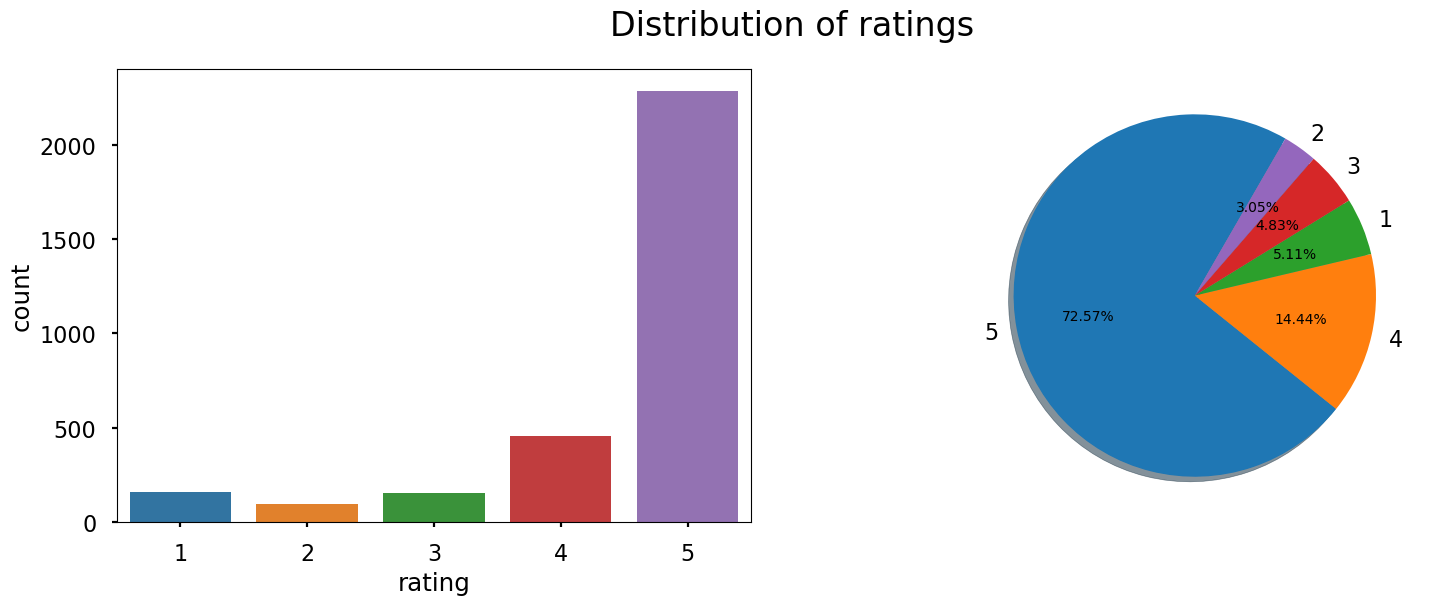

In [6]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (18, 6), dpi = 100)
sns.countplot(data["rating"], ax = axes[0])
axes[1].pie(data["rating"].value_counts(), labels = data["rating"].value_counts().index, autopct = '%1.2f%%', shadow = True, startangle=60)
fig.suptitle('Distribution of ratings', fontsize = 24)
plt.savefig('rating_distribution.png')
plt.show()


# As we can see both objectives have imbalanced classes
- Maybe we can experiment some downsampling methods to check if unsupervised methods are invariant to imbalanced datasets

# Let's go further and analyze the number of words and lenghts in reviews

In [7]:
data["length"] = data["review"].apply(lambda x: len(x))
data["words"]  = data["review"].apply(lambda x: len(x.split(" ")))
display(data)

,review,rating,feedback,length,words
0,Love my Echo!,5,1,13,3
1,Loved it!,5,1,9,2
2,"Sometimes while playing a game, you can answer...",4,0,195,39
3,I have had a lot of fun with this thing. My 4 ...,5,1,172,34
4,Music,5,1,5,1
...,...,...,...,...,...
3145,"Perfect for kids, adults and everyone in betwe...",5,1,50,8
3146,"Listening to music, searching locations, check...",5,1,135,23
3147,"I do love these things, i have them running my...",5,1,441,83
3148,Only complaint I have is that the sound qualit...,5,1,380,76


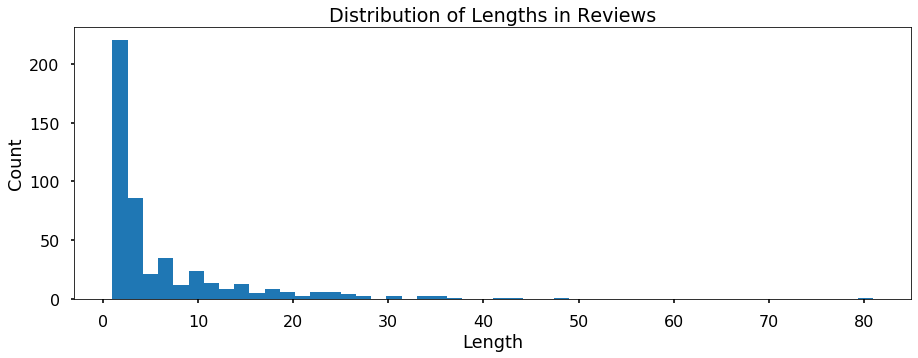

In [8]:
data['length'].value_counts().plot.hist(figsize = (15, 5), bins = 50)
plt.title('Distribution of Lengths in Reviews')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

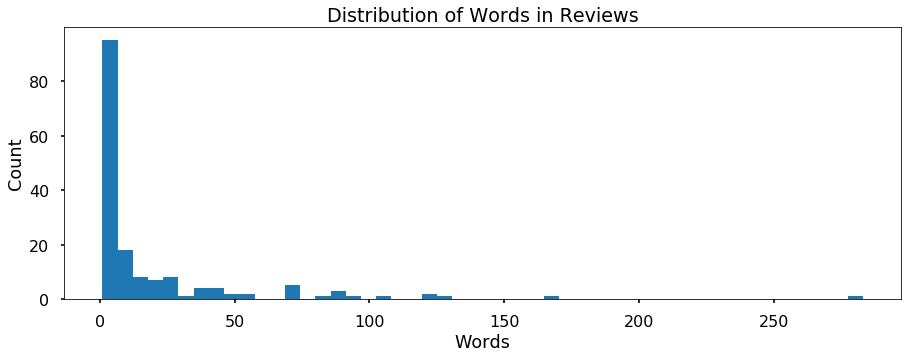

In [9]:
data['words'].value_counts().plot.hist(figsize = (15, 5), bins = 50)
plt.title('Distribution of Words in Reviews')
plt.xlabel('Words')
plt.ylabel('Count')
plt.show()

# As we can observe the most of the reviews have short lengths
- Let's check some random samples

In [10]:
lengths, counts = np.unique(data.length.values, return_counts = True)

for length, sample in [(1, 20), (2, 10), (3, 5), (4, 5), (5, 5)]:
    print("Samples for reviews of length: {}".format(length))
    display(data[data['length'] == length]['review'].iloc[0 : sample])

for length in [100, 150, 1360]:
    print("Samples for reviews of length: {}".format(length))
    display(data[data['length'] == length]['review'].iloc[0])

Samples for reviews of length: 1


60      😍
85       
183      
219      
374      
406      
524      
654      
755     😍
780      
878      
914      
1094     
1112     
1119     
1150     
1151     
1275     
1321     
1354     
Name: review, dtype: object

Samples for reviews of length: 2


1692    👍🏻
1937    A+
2179    ok
2436    😄😄
Name: review, dtype: object

Samples for reviews of length: 3


1200    Meh
1545    Fun
1849    Fun
Name: review, dtype: object

Samples for reviews of length: 4


143    Cool
220    Cool
438    Love
473    None
838    Cool
Name: review, dtype: object

Samples for reviews of length: 5


4      Music
44     Great
323    Great
445    Great
591    A++++
Name: review, dtype: object

Samples for reviews of length: 100


'Great for my office. I use this daily in many ways, to include spelling for me and background music.'

Samples for reviews of length: 150


"Got this on Amazon prime with the ring pro. Work really great. Being the lazy guy I am I don't need to go see who at my door anymore while I'm gaming."

Samples for reviews of length: 1360


'I love everything about it. I love that the echo plus turns on and off my light. It can also dim them with voice commands. I also like listening to my kindle books even the ones that I didn’t purchased  audibles for. I like that it can play my music from Amazon music, pandora, tunein, I heart radio and Spotify. Echo can even play my local radio station. I love that the echo is connected to my TiVo Bolt. This allows TiVo to pause, stop and play whatever I want with a simple voice command. I love that I can reorder items that I purchased on Amazon and that the echo plus notifies me when my order is mailed, when it will be delivered and when the package has been delivered.  The only three dislikes that I have is that if you’re up too close or to far the echo doesn’t respond. So I think they need to improve the microphone. And I wish the speaker was better. The speakers are okay but could be improved. Also I have the echo dot and it never has given me any problems with the internet. Well 

# There are some empty reviews
- Before we remove them let's check if there is some type of correlation that we can extract and use

In [11]:
data['is_space'] = data['review'].apply(lambda x: x == ' ')
display(data[data['is_space'] == True])

,review,rating,feedback,length,words,is_space
85,,5,1,1,2,True
183,,3,0,1,2,True
219,,5,1,1,2,True
374,,1,0,1,2,True
406,,1,0,1,2,True
...,...,...,...,...,...,...
3114,,3,0,1,2,True
3120,,5,1,1,2,True
3123,,4,0,1,2,True
3126,,5,1,1,2,True


In [12]:
display(data.groupby("rating")["is_space"].describe())

,count,unique,top,freq
rating,,,,
1,161,2,False,146
2,96,2,False,92
3,152,2,False,140
4,455,2,False,447
5,2286,2,False,2246


# There are 79 empty reviews and seem to be uniform distributed
- I think it's save to remove them and check the length distribution again

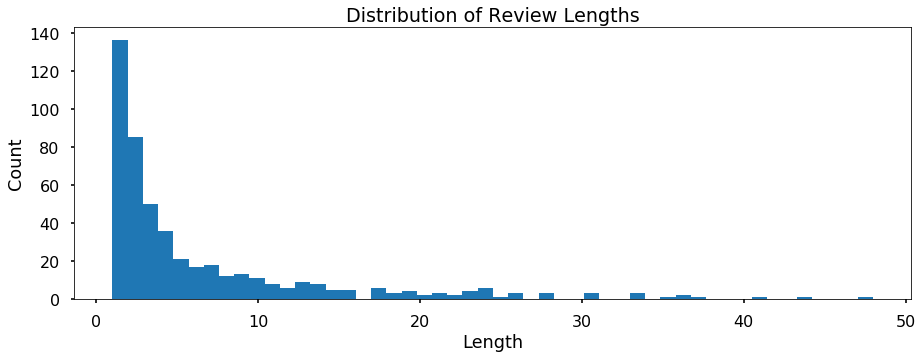

In [13]:
data.drop(data[data['is_space'] == True].index, axis = 0, inplace = True)
data.drop(['is_space'], axis = 1, inplace = True)

data['length'].value_counts().plot.hist(figsize = (15, 5), bins = 50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length')
plt.ylabel('Count')
plt.savefig("length_distribution.png")
plt.show()

In [14]:
lengths, counts = np.unique(data.length.values, return_counts = True)

print("All Lengths in dataset:")
print(lengths)
print("The occurrence for each one:")
print(counts)

All Lengths in dataset:
[   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   22   23   24   25   26   27   28
   29   30   31   32   33   34   35   36   37   38   39   40   41   42
   43   44   45   46   47   48   49   50   51   52   53   54   55   56
   57   58   59   60   61   62   63   64   65   66   67   68   69   70
   71   72   73   74   75   76   77   78   79   80   81   82   83   84
   85   86   87   88   89   90   91   92   93   94   95   96   97   98
   99  100  101  102  103  104  105  106  107  108  109  110  111  112
  113  114  115  116  117  118  119  120  121  122  123  124  125  126
  127  128  129  130  131  132  133  134  135  136  137  138  139  140
  141  142  143  144  145  146  147  148  149  150  151  152  153  154
  155  156  157  158  159  160  161  162  163  164  165  166  167  168
  169  170  171  172  173  174  175  176  177  179  180  181  182  183
  184  185  186  187  188  189  190  191  192  193  1

In [15]:
for length, sample in [(1, 20), (2, 10), (3, 5), (4, 5), (5, 5)]:
    print("Samples for reviews of length: {}".format(length))
    display(data[data['length'] == length]['review'].iloc[0 : sample])

Samples for reviews of length: 1


60     😍
755    😍
Name: review, dtype: object

Samples for reviews of length: 2


1692    👍🏻
1937    A+
2179    ok
2436    😄😄
Name: review, dtype: object

Samples for reviews of length: 3


1200    Meh
1545    Fun
1849    Fun
Name: review, dtype: object

Samples for reviews of length: 4


143    Cool
220    Cool
438    Love
473    None
838    Cool
Name: review, dtype: object

Samples for reviews of length: 5


4      Music
44     Great
323    Great
445    Great
591    A++++
Name: review, dtype: object

# As we can observe, we have emoticons
- Let's try to see how many he have in dataset

In [16]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)

data['emojis'] = data['review'].apply(lambda x: len(re.findall(emoji_pattern, x)))

display(data)

emojis, counts = np.unique(data.emojis.values, return_counts = True)

print("Number of emojis in each review:")
print(emojis)
print("The occurrence for each one:")
print(counts)

,review,rating,feedback,length,words,emojis
0,Love my Echo!,5,1,13,3,0
1,Loved it!,5,1,9,2,0
2,"Sometimes while playing a game, you can answer...",4,0,195,39,0
3,I have had a lot of fun with this thing. My 4 ...,5,1,172,34,0
4,Music,5,1,5,1,0
...,...,...,...,...,...,...
3145,"Perfect for kids, adults and everyone in betwe...",5,1,50,8,0
3146,"Listening to music, searching locations, check...",5,1,135,23,0
3147,"I do love these things, i have them running my...",5,1,441,83,0
3148,Only complaint I have is that the sound qualit...,5,1,380,76,0


Number of emojis in each review:
[0 1 2]
The occurrence for each one:
[3041   29    1]


# Let's take a more closer look to the reviews with emojis

,review,rating,feedback,length,words,emojis
49,No different than Apple. To play a specific li...,3,0,208,41,1
60,😍,5,1,1,1,1
134,So far I like it 🤓,5,1,18,6,1
229,Best thing I've invested in in a while thank y...,5,1,61,13,1
447,Works perfect no wear and tear on the device I...,5,1,91,19,1
541,Well I’m a big fan of echoes these ones went I...,5,1,95,20,1
681,Seems to have trouble hearing me when I say th...,3,0,227,43,1
684,I bought this for a family member as a gift. I...,5,1,107,25,1
744,No different than Apple. To play a specific li...,3,0,208,41,1
755,😍,5,1,1,1,1


['No different than Apple. To play a specific list of music you must have an Amazon of Spotify “plus/prime/etc” account.  So you must pay to play “your” music.  3 stars for that reason.  Everything else is 👍🏻 .'
 '😍' 'So far I like it 🤓'
 "Best thing I've invested in in a while thank you so much 😁😁😁😁"
 'Works perfect no wear and tear on the device I love Alexa working on making my home smart 😂'
 'Well I’m a big fan of echoes these ones went I’m my bathrooms.  Works just great as expected 👍🏾'
 'Seems to have trouble hearing me when I say the wake word despite being trained to my voice... Wonder if this has something to do with buying it refurbished. Our google home mini has no problems hearing us 😬 and is much louder.'
 'I bought this for a family member as a gift. I called her to see how she likes it & she said she loves it‼️'
 'No different than Apple. To play a specific list of music you must have an Amazon of Spotify “plus/prime/etc” account.  So you must pay to play “your” music.  

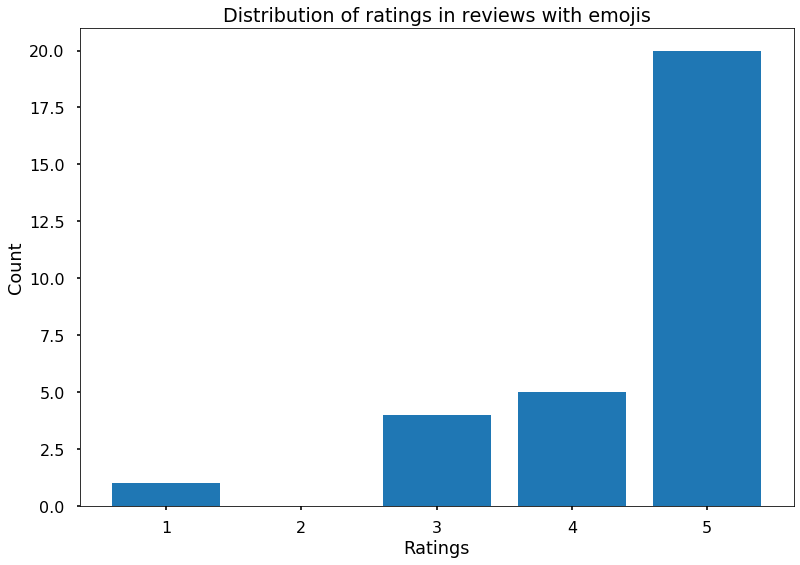

In [17]:
emojis_reviews = data[data["emojis"] != 0]

display(emojis_reviews)

print(emojis_reviews.review.values)

emoji_ratings   = emojis_reviews.rating.values
ratings, counts = np.unique(emoji_ratings, return_counts = True)

plt.bar(ratings, counts)
plt.title("Distribution of ratings in reviews with emojis")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.savefig("emoji_distribution.png")
plt.show()

# It seems that emojis in this dataset are more likely in the positive ratings
- This leads us to the conclusion that we might not want to remove emojis but rather use them embedded as text

# Let's try to group the dataset by ratings and check correlations


In [18]:
display(data.groupby("rating")["length"].describe())

,count,mean,std,min,25%,50%,75%,max
rating,,,,,,,,
1,146.0,214.931507,213.245937,10.0,58.0,135.0,288.75,1124.0
2,92.0,259.978261,270.279748,3.0,95.5,167.5,317.00,1686.0
3,140.0,224.978571,276.581300,13.0,59.0,154.5,291.25,1954.0
4,447.0,181.697987,216.531226,4.0,36.0,102.0,246.00,1360.0
5,2246.0,110.357524,152.781962,1.0,28.0,66.0,137.00,2851.0


In [19]:
display(data.groupby("rating")["words"].describe())

,count,mean,std,min,25%,50%,75%,max
rating,,,,,,,,
1,146.0,40.746575,40.215250,2.0,11.25,26.5,57.00,230.0
2,92.0,50.184783,52.284288,1.0,17.75,33.0,60.25,324.0
3,140.0,43.650000,52.935542,2.0,12.00,30.0,57.25,361.0
4,447.0,35.205817,41.901204,1.0,7.00,20.0,48.50,264.0
5,2246.0,21.609528,29.611370,1.0,5.25,13.0,27.00,526.0


# With a higher rating, the lower the number words or characters

# Now let's check the most common N-grams for each rating category

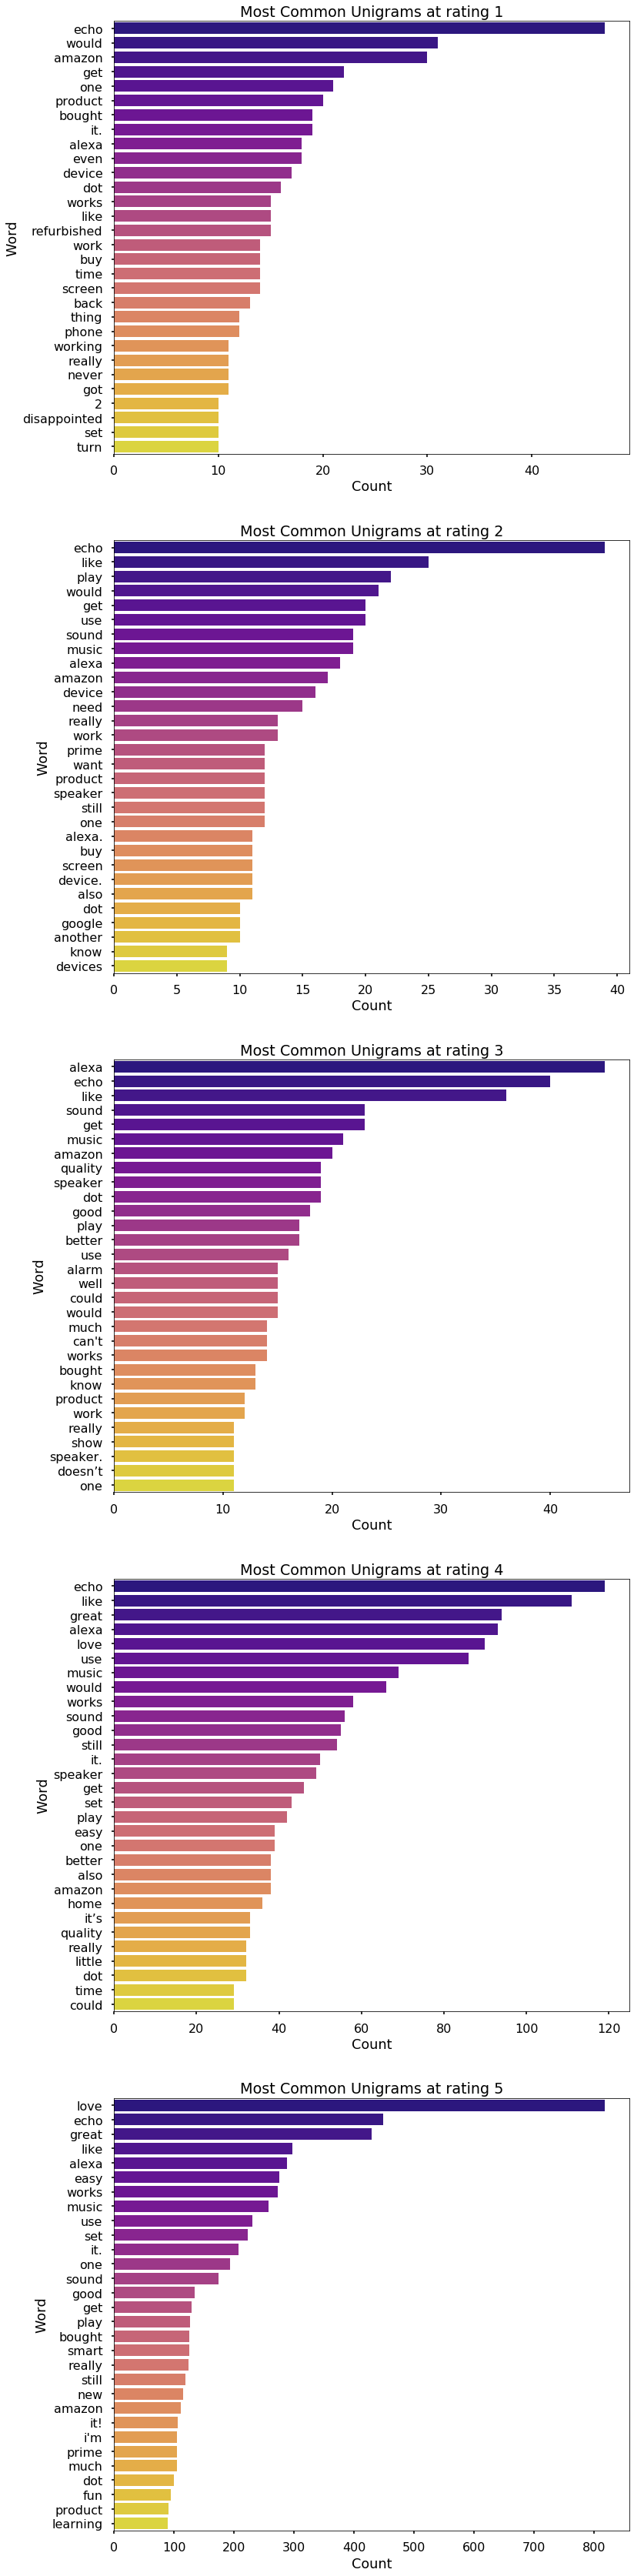

In [20]:
subsets = [
    data[data['rating'] == 1]['review'],
    data[data['rating'] == 2]['review'],
    data[data['rating'] == 3]['review'],
    data[data['rating'] == 4]['review'],
    data[data['rating'] == 5]['review'],
]

fig, axes = plt.subplots(5, 1, figsize=(12, 60))
for (i, (subset, ax)) in enumerate(zip(subsets, axes)):
    reviews = subset.str.split()
    reviews = reviews.values.tolist()    
    corpus = [word.lower() for text in reviews for word in text]
    corpus = [word for word in corpus if word not in STOPS]

    counter = Counter(corpus)
    most = counter.most_common()

    x = [word  for word, _ in most[:30]]
    y = [count for _, count in most[:30]]
    
    sns.barplot(x = y, y = x, palette = 'plasma', ax = ax)
    axes[i].set_title('Most Common Unigrams at rating {}'.format(i + 1))
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('Word')

# Let's check the bigrams...

In [21]:
def ngram(subsets, n, title):

    def _generate_top_ngrams(corpus, n):
        vec = CountVectorizer(ngram_range = (n, n), max_df = 0.9, stop_words = STOPS).fit(corpus)
        bag_of_words = vec.transform(corpus)
        
        sum_words = bag_of_words.sum(axis = 0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
        
        return words_freq
    
    fig, axes = plt.subplots(5, 1, figsize = (12, 60))
    
    for (i, (subset, ax)) in enumerate(zip(subsets, axes)):        
        top_n_bigrams = _generate_top_ngrams(subset, n)[: 30]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x = y, y = x, palette = 'plasma', ax = ax)
        axes[i].set_title('Most Common {} at rating {}'.format(title, i + 1))
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel('Word')    

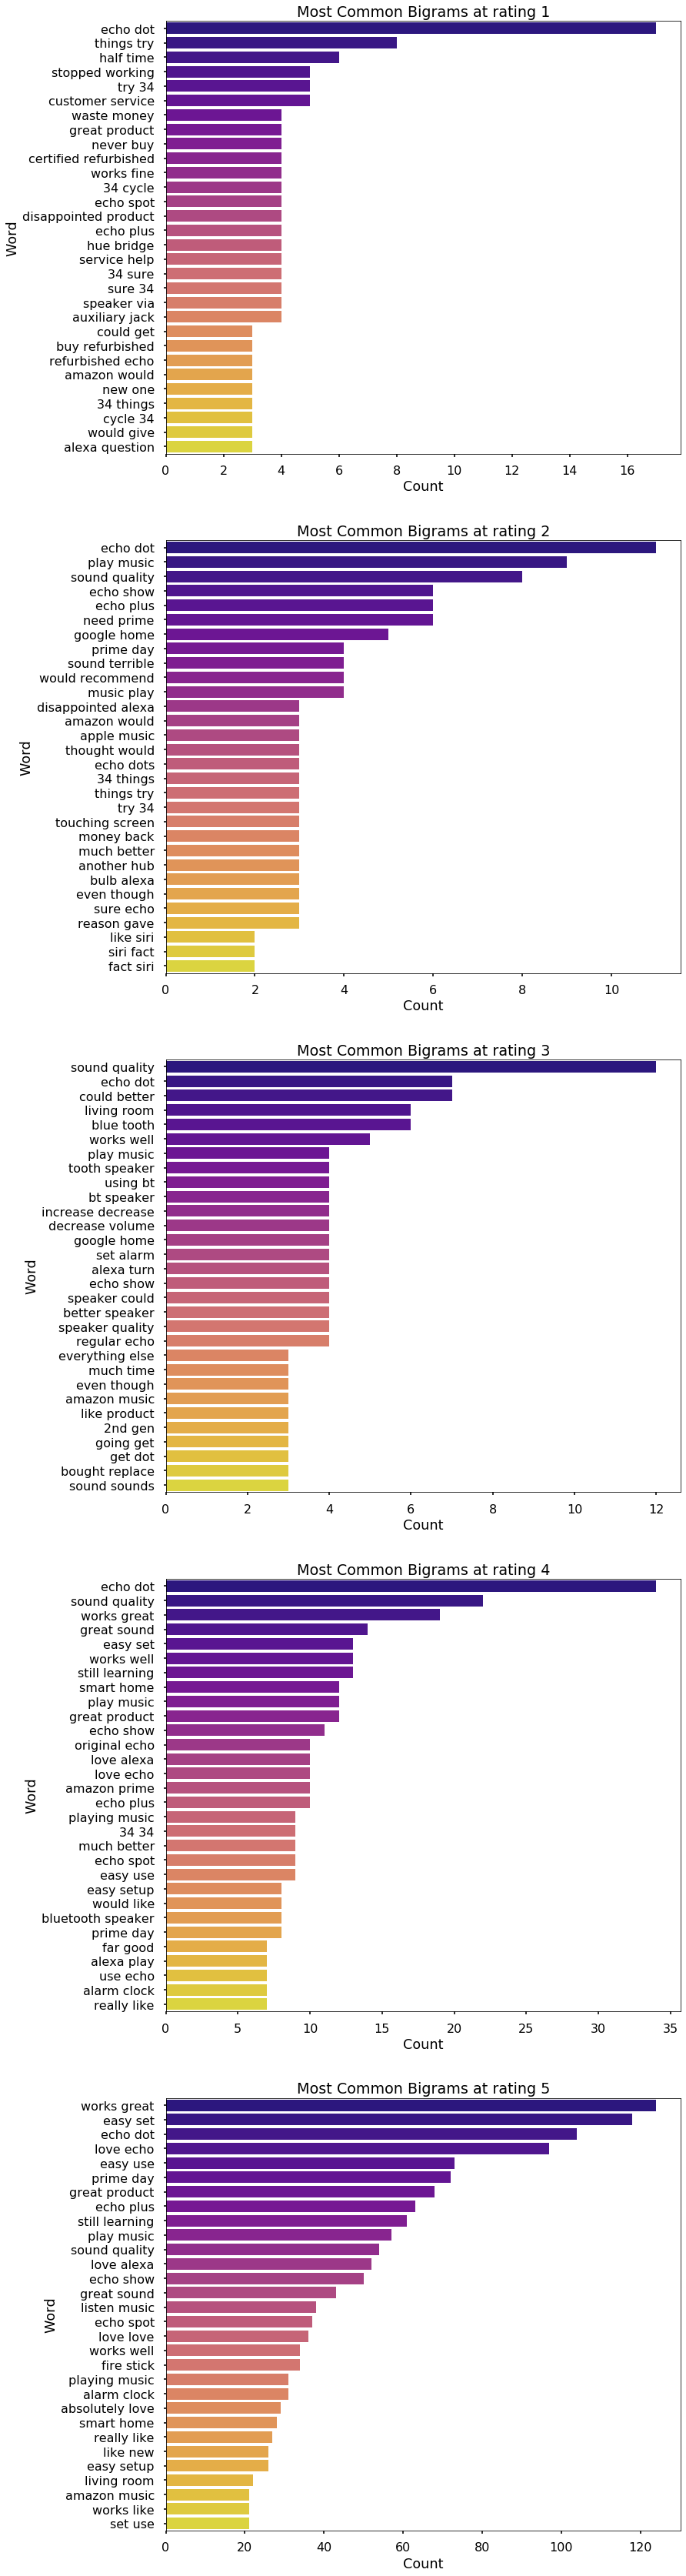

In [22]:
ngram(subsets, 2, "Bigrams")

# There are some numbers in the dataset
- Those might be irelevant and might lead to classification errors
- But to be sure we need to see how the reviews with numbers are distributed

In [23]:
data['has_numbers'] = data['review'].apply(lambda x: any(char.isdigit() for char in x))
has_numbers = data[data['has_numbers'] == True]
display(has_numbers)

,review,rating,feedback,length,words,emojis,has_numbers
3,I have had a lot of fun with this thing. My 4 ...,5,1,172,34,0,True
7,I think this is the 5th one I've purchased. I'...,5,1,221,40,0,True
10,"I sent it to my 85 year old Dad, and he talks ...",5,1,63,15,0,True
18,We love the size of the 2nd generation echo. S...,5,1,86,16,0,True
24,"I got a second unit for the bedroom, I was exp...",3,0,179,35,0,True
...,...,...,...,...,...,...,...
3093,Use as my 3rd dot. Bought so my husband would ...,5,1,118,24,0,True
3107,Easy to connect and the skills created for our...,5,1,85,17,0,True
3112,This is my second Echo to purchase -- the pri...,5,1,193,39,0,True
3124,Love my Alexa! Actually have 3 throughout the ...,5,1,128,21,0,True


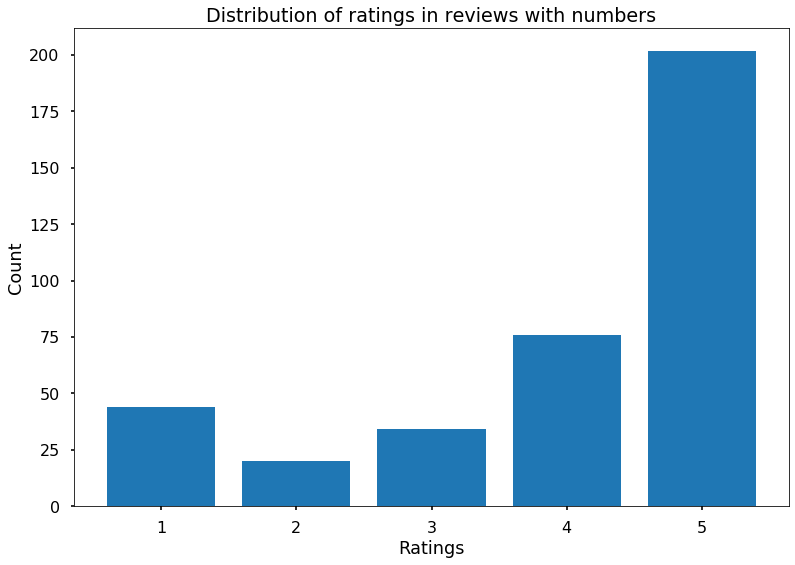

In [24]:
numbers, counts = np.unique(has_numbers.rating, return_counts = True)

plt.bar(numbers, counts)
plt.title("Distribution of ratings in reviews with numbers")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

# As anticipated, the numbers do not reveal any information about target
- The reviews that contain numbers are uniform distributed, so it's safe to remove the number characters

# Now it's time for the preprocessing step

In [25]:
class TextCleaner:
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.stop = STOPS
        self.wnl  = WordNetLemmatizer()
        
        self.clean()
        
    def clean(self):
        aux_columns = ["text_clean", "tokenized", "lower", "stopwords_removed", "pos_tags", "wordnet_pos", "lemmatized"]
        
        self.data['text_clean'] = self.data['review'].apply(lambda x: TextCleaner.remove_URL(x))
        self.data['text_clean'] = self.data['text_clean'].apply(lambda x: TextCleaner.encode_emoji(x))
        self.data['text_clean'] = self.data['text_clean'].apply(lambda x: TextCleaner.remove_html(x))
        self.data['text_clean'] = self.data['text_clean'].apply(lambda x: TextCleaner.remove_punct(x))
        self.data['text_clean'] = self.data['text_clean'].apply(lambda x: TextCleaner.remove_accented_chars(x))
        self.data['text_clean'] = self.data['text_clean'].apply(lambda x: TextCleaner.remove_numbers(x))
        self.data['text_clean'] = self.data['text_clean'].apply(lambda x: TextCleaner.remove_whitespace(x))
        self.data['text_clean'] = self.data['text_clean'].apply(lambda x: TextCleaner.expand_contractions(x))
        self.data['tokenized']  = self.data['text_clean'].apply(word_tokenize)

        self.data['lower'] = self.data['tokenized'].apply(lambda x: [word.lower() for word in x])

        self.data['stopwords_removed'] = self.data['lower'].apply(lambda x: [word for word in x if word not in self.stop])

        self.data['pos_tags'] = self.data['stopwords_removed'].apply(nltk.tag.pos_tag)
        
        self.data['wordnet_pos'] = self.data['pos_tags'].apply(lambda x: [(word, TextCleaner.get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
    
        self.data['lemmatized'] = self.data['wordnet_pos'].apply(lambda x: [self.wnl.lemmatize(word, tag) for word, tag in x])
        
        self.data['lemmatized'] = self.data['lemmatized'].apply(lambda x: [word for word in x if word not in self.stop])
        
        self.data['final_text'] = [' '.join(map(str, l)) for l in self.data['lemmatized']]
        
        self.data['final_text'] = self.data['final_text'].apply(lambda x: x.strip())
        
        self.data.drop(aux_columns, inplace = True, axis = 1)

    def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'', text)

    def remove_emoji(string):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002500-\U00002BEF"  # chinese char
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
        
        return emoji_pattern.sub(r'', string)

    def encode_emoji(text):
        return emoji.demojize(text, delimiters=(" ", " "))
    
    def expand_contractions(text):
        text = contractions.fix(text)
        return text
    
    def remove_numbers(text):
        return re.sub(r'\d+', '', text)
    
    def remove_html(text):
        html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
        return re.sub(html, '', text)

    def remove_accented_chars(text):
        text = unidecode.unidecode(text)
        return text

    def remove_punct(text):
        table = str.maketrans('', '', string.punctuation)
        return text.translate(table)
    
    def remove_whitespace(text):
        text = text.strip()
        return " ".join(text.split())

    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN


In [26]:
clean_data = TextCleaner(data).data
display(clean_data)

,review,rating,feedback,length,words,emojis,has_numbers,final_text
0,Love my Echo!,5,1,13,3,0,False,love echo
1,Loved it!,5,1,9,2,0,False,love
2,"Sometimes while playing a game, you can answer...",4,0,195,39,0,False,sometimes play game answer question correctly ...
3,I have had a lot of fun with this thing. My 4 ...,5,1,172,34,0,True,lot fun thing yr old learn dinosaur control li...
4,Music,5,1,5,1,0,False,music
...,...,...,...,...,...,...,...,...
3145,"Perfect for kids, adults and everyone in betwe...",5,1,50,8,0,False,perfect kid adult everyone
3146,"Listening to music, searching locations, check...",5,1,135,23,0,False,listen music search location check time look w...
3147,"I do love these things, i have them running my...",5,1,441,83,0,False,love thing run entire home tv light thermostat...
3148,Only complaint I have is that the sound qualit...,5,1,380,76,0,False,complaint sound quality great mostly use comma...


In [27]:
subsets = [
    data[data['rating'] == 1]['final_text'],
    data[data['rating'] == 2]['final_text'],
    data[data['rating'] == 3]['final_text'],
    data[data['rating'] == 4]['final_text'],
    data[data['rating'] == 5]['final_text'],
]

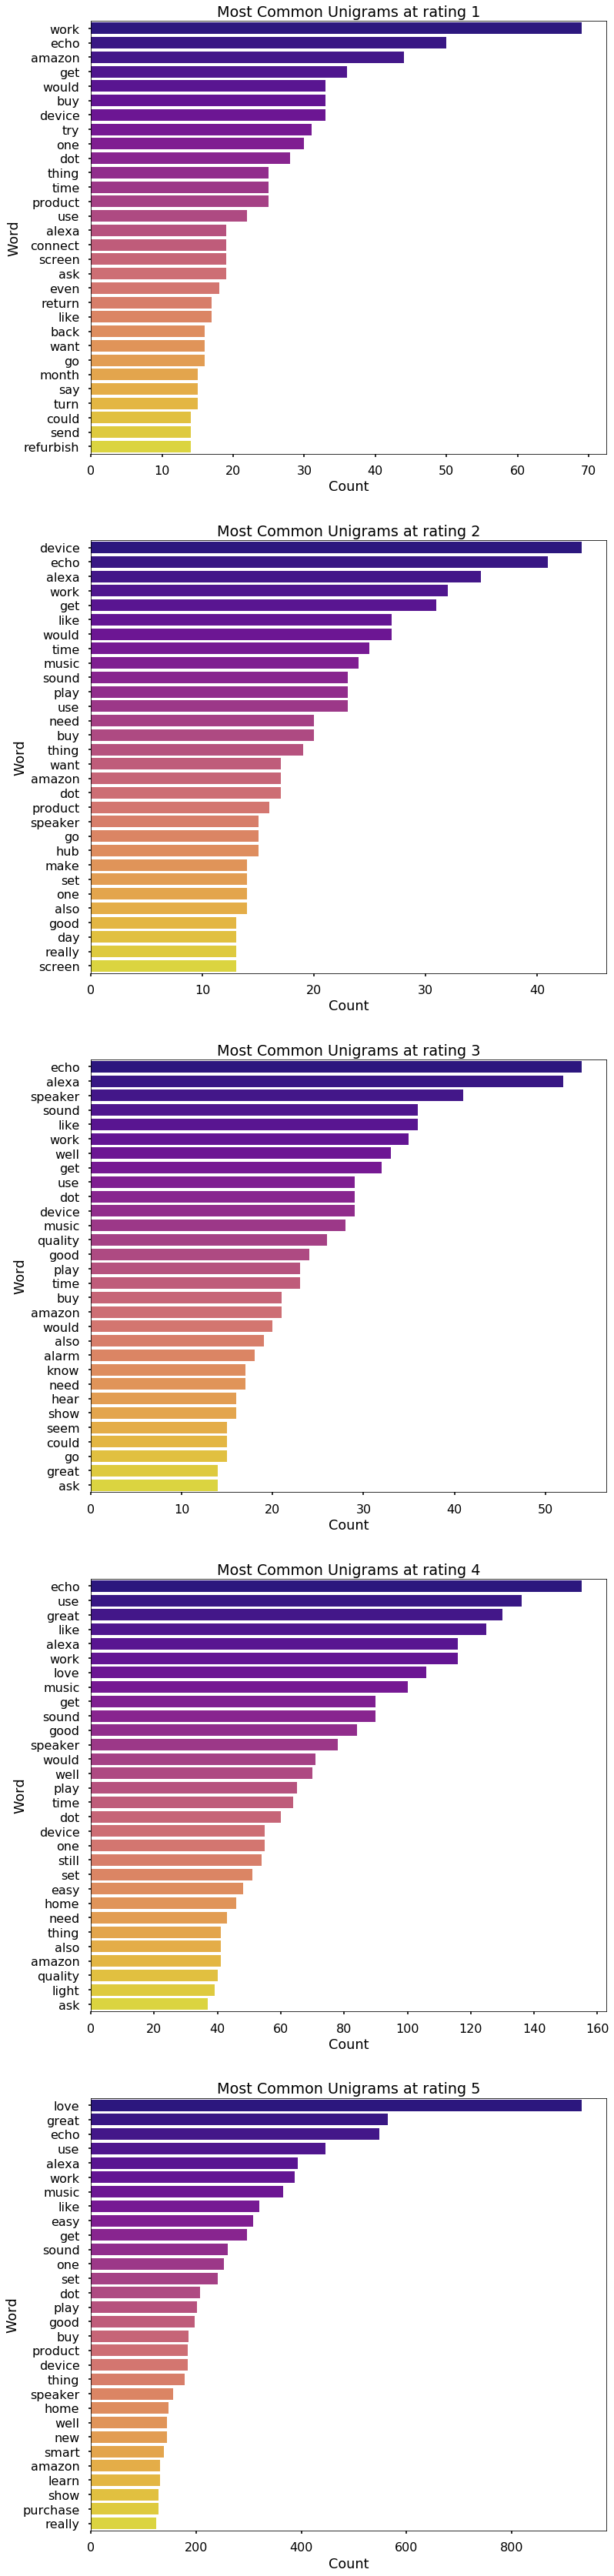

In [28]:
ngram(subsets, 1, "Unigrams")

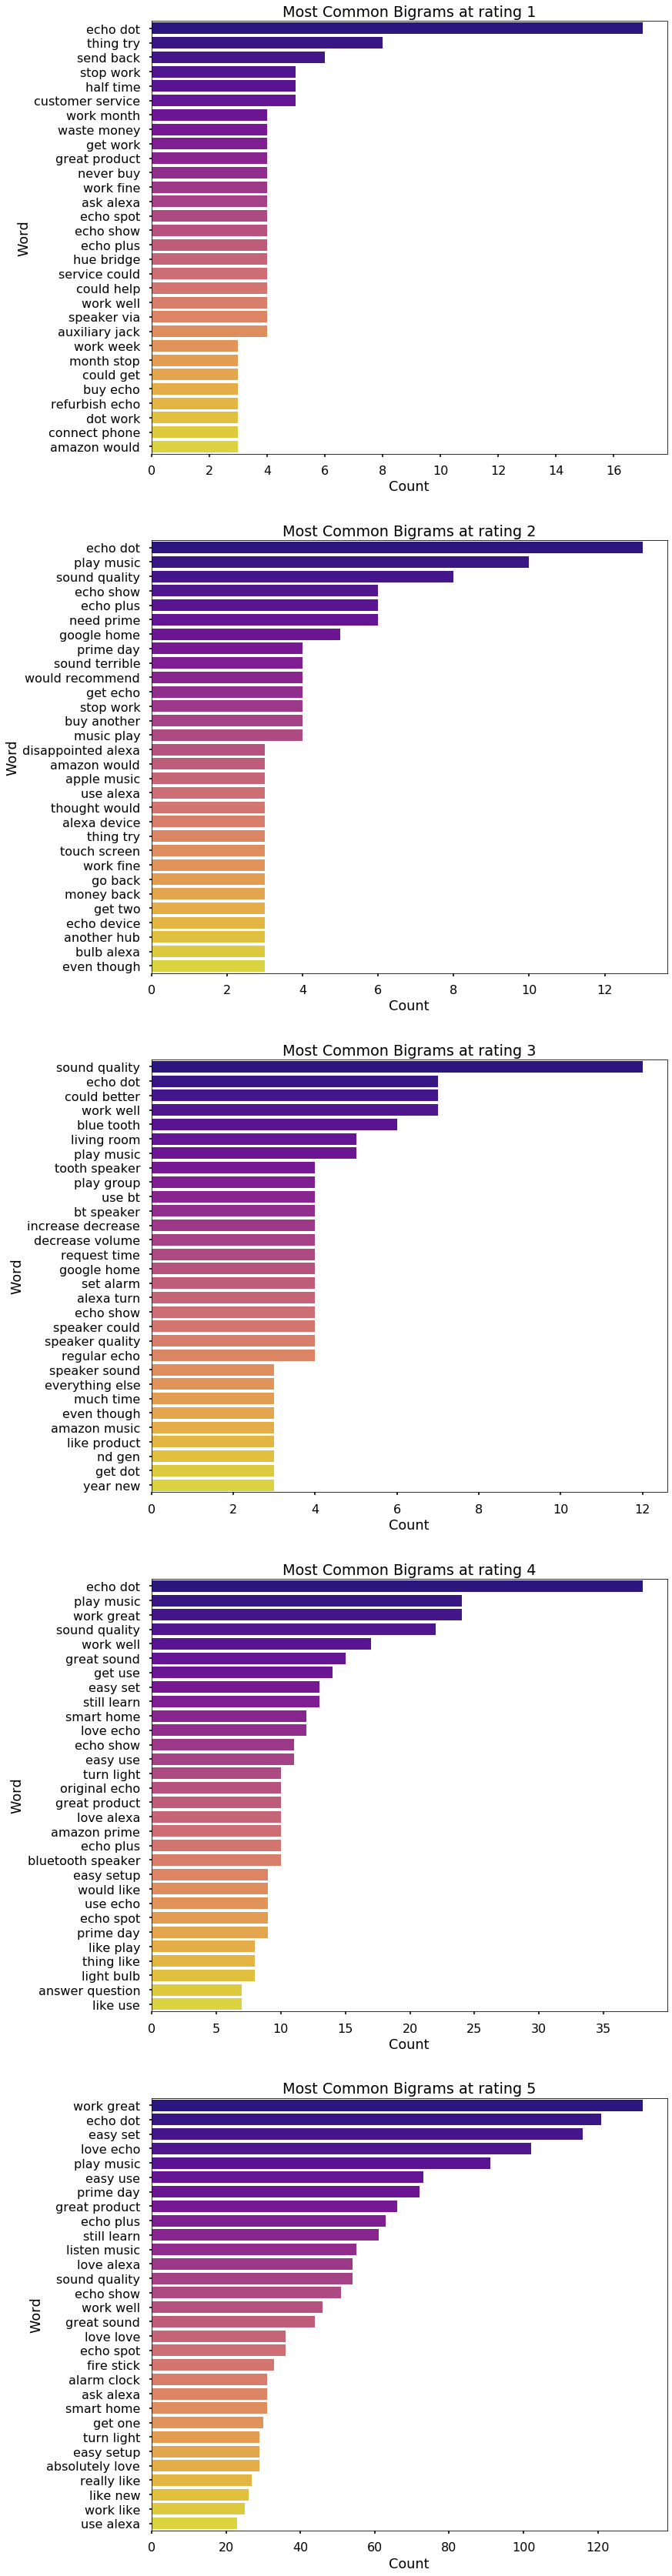

In [29]:
ngram(subsets, 2, "Bigrams")

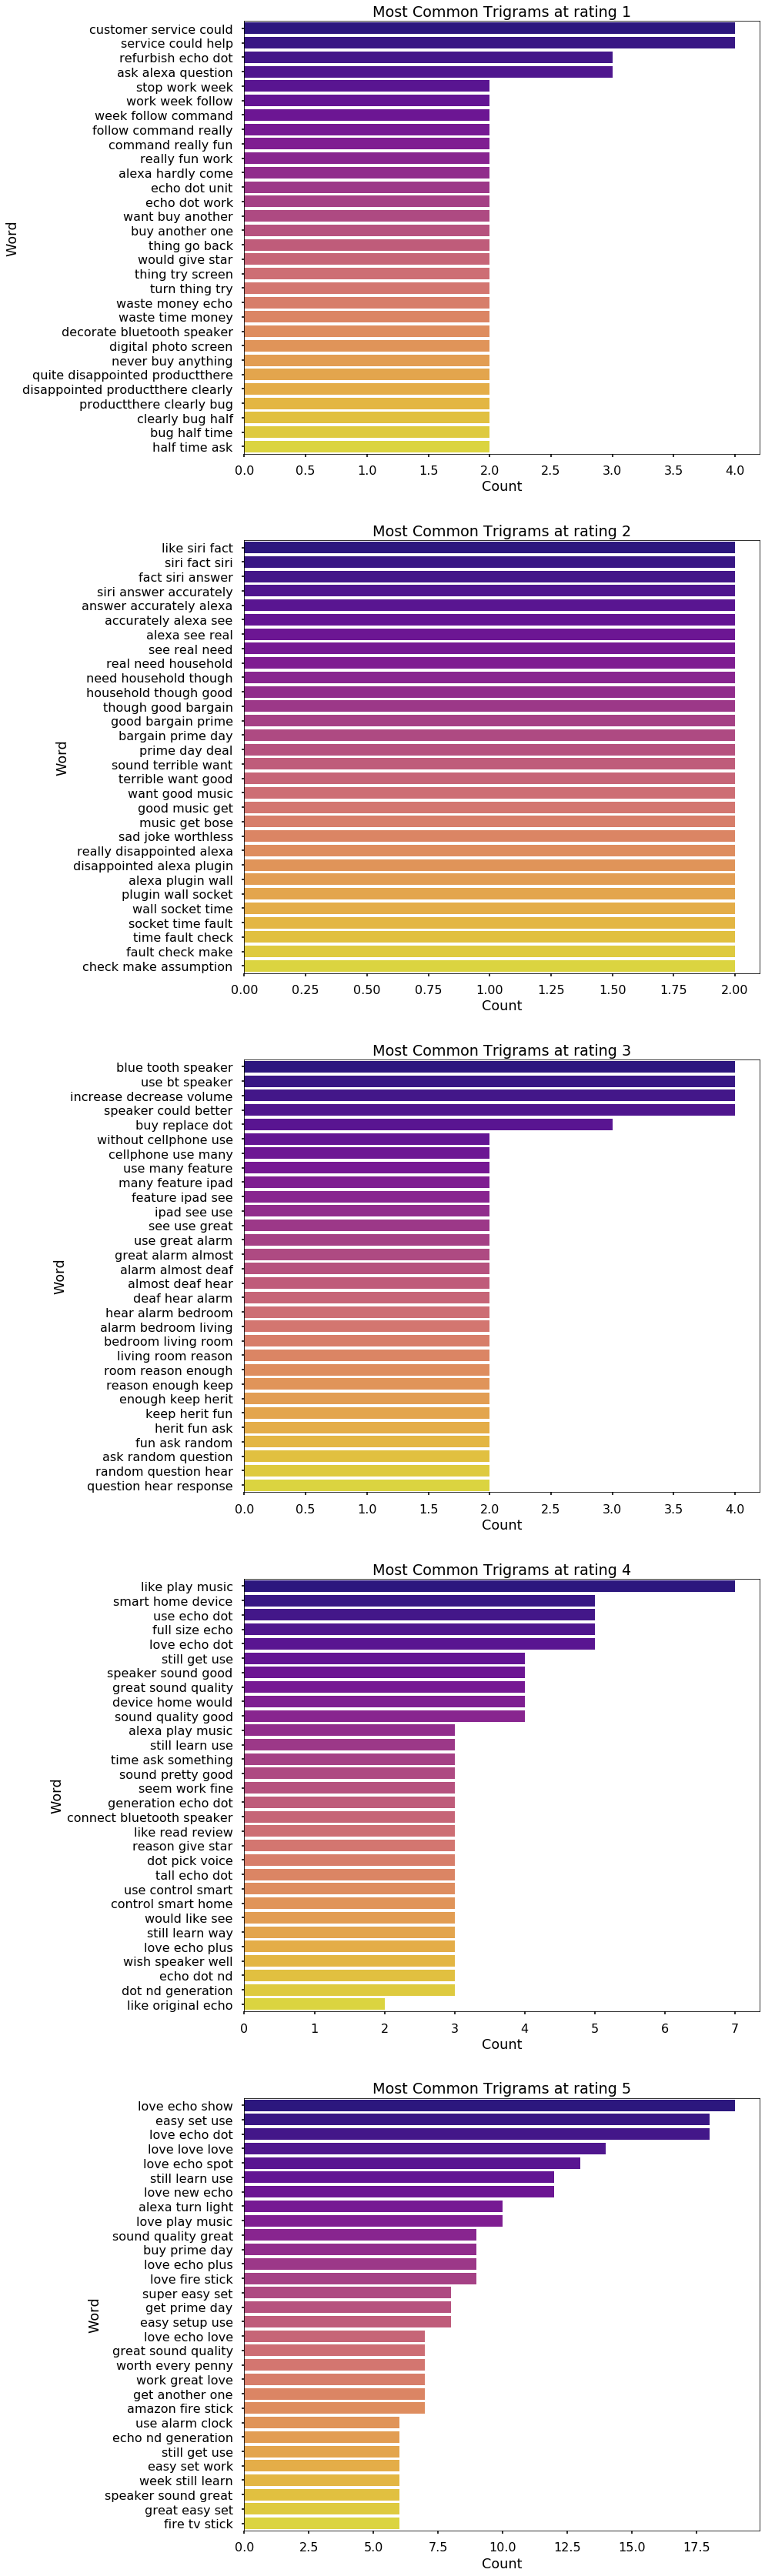

In [30]:
ngram(subsets, 3, "Trigrams")

# It seems to be some separation in ratings
- Based on N-grams anlysis we can observe that there is some degree of separation
- In the low rating (rating 1) we see in reviews we frequently "send back", "customer service", "waste money"
- In the middle rating (rating 3) we see in reviews we frequently "could better", "work well", "sound quality"
- In the middle rating (rating 3) we see in reviews we frequently "work great", "love echo", "easy use"

# Many words with very less meaning
- In this dataset we see words like 'alexa', 'amazon', 'echo' that are very frequent in each rating category, but carry very little information
- So it would be a good idea to remove them

In [31]:
def get_most_common_words_by_rating(subsets, n):
    
    rating_words = []
    for subset in subsets:  
        vec = CountVectorizer(ngram_range = (n, n), max_df = 0.9, stop_words = STOPS).fit(subset)
        bag_of_words = vec.transform(subset)
        sum_words = bag_of_words.sum(axis = 0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
        
        top_n_bigrams = words_freq[: 30]
        x, _ = map(list, zip(*top_n_bigrams))
        
        rating_words.append(set(x))
    
    return rating_words

In [32]:
words = get_most_common_words_by_rating(subsets, 1)
useless = set.intersection(words[0], words[1], words[2], words[3], words[4])
print(useless)

{'dot', 'alexa', 'use', 'amazon', 'get', 'device', 'echo', 'work', 'like'}


In [33]:
clean_data['final_text'] = clean_data['final_text'].apply(word_tokenize)
clean_data['final_text'] = clean_data['final_text'].apply(lambda x: [word for word in x if word not in useless])
clean_data['final_text'] = [' '.join(map(str, l)) for l in clean_data['final_text']]

clean_data['is_space'] = clean_data['final_text'].apply(lambda x: x == ' ' or x == '')
display(clean_data[clean_data['is_space'] == True])

clean_data.drop(clean_data[clean_data['is_space'] == True].index, axis = 0, inplace = True)
clean_data.drop(['is_space'], axis = 1, inplace = True)

,review,rating,feedback,length,words,emojis,has_numbers,final_text,is_space
31,I like it,4,0,9,3,0,False,,True
78,I LIKE IT ALL,5,1,13,4,0,False,,True
235,Liked 100%,5,1,10,2,0,True,,True
240,Like it to do more,4,0,18,5,0,False,,True
369,not working,1,0,11,2,0,False,,True
372,It works,5,1,8,2,0,False,,True
476,It works,5,1,8,2,0,False,,True
583,It works,4,0,8,2,0,False,,True
591,A++++,5,1,5,1,0,False,,True
726,I like it,4,0,9,3,0,False,,True


In [34]:
subsets = [
    clean_data[clean_data['rating'] == 1]['final_text'],
    clean_data[clean_data['rating'] == 2]['final_text'],
    clean_data[clean_data['rating'] == 3]['final_text'],
    clean_data[clean_data['rating'] == 4]['final_text'],
    clean_data[clean_data['rating'] == 5]['final_text'],
]

display(clean_data['final_text'])

0                                                    love
1                                                    love
2       sometimes play game answer question correctly ...
3       lot fun thing yr old learn dinosaur control li...
4                                                   music
                              ...                        
3145                           perfect kid adult everyone
3146    listen music search location check time look w...
3147    love thing run entire home tv light thermostat...
3148    complaint sound quality great mostly command t...
3149                                                 good
Name: final_text, Length: 3049, dtype: object

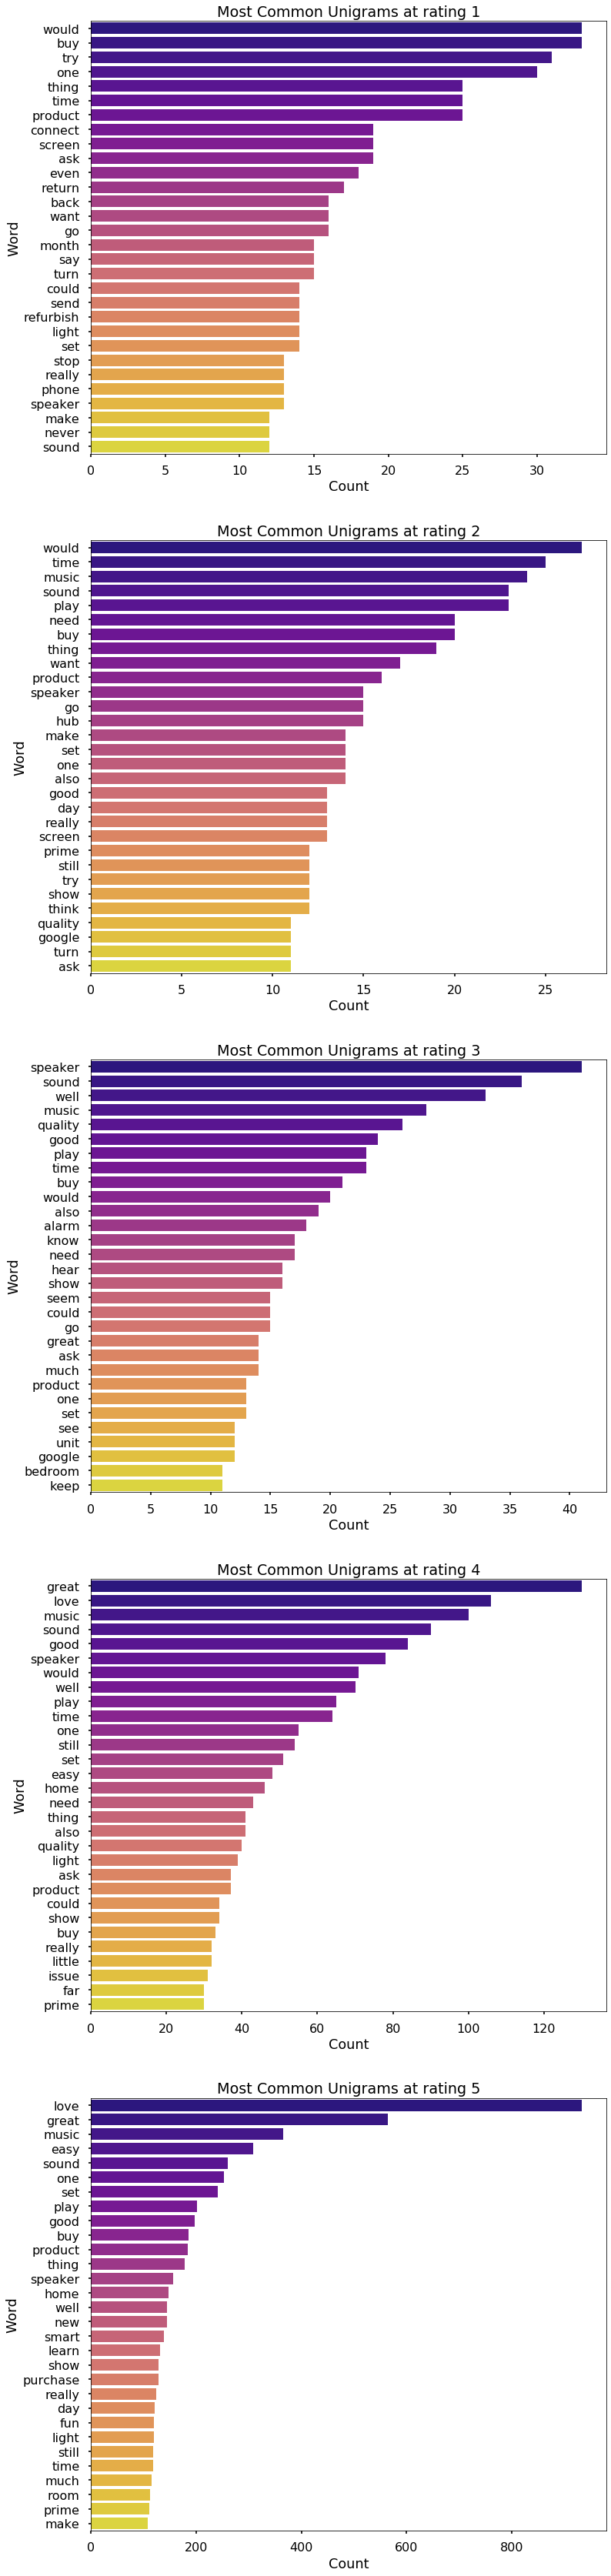

In [35]:
ngram(subsets, 1, "Unigrams")

# The main two problems of the dataset
- The imbalance of target classes, which we can try to solve with subsampling
- The dataset inconsistency, this observation is based on the fact that a review like 'I like it' can easily be a 3 or 5 star rating, which makes the problem less separable

# Generating Embeddings from Universal Sentence Encoder
- The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

For more information the source is: https://tfhub.dev/google/universal-sentence-encoder/4

In [36]:
embeddings = create_embeddings_use(clean_data, "final_text")

[create_embeddings_use] -> time 3.4140825271606445's


In [37]:
# lengths = clean_data.length.values.reshape(-1, 1)

# scaler  = StandardScaler()
# lengths = scaler.fit_transform(lengths)

# embeddings['length'] = lengths

# Structure of the following experiments
- For each task of clustering (clustering based on feedback and ratings) will compare two unsupervised methods respectively KMeans Clustering and GaussianMixture, and a supervised baseline represented by a standard LogisticRegression
- For each task will plot a PCA in 3 dimensions colored by labels to check if the data points are close to something separable


For each unsupervised method in each task will do 4 steps:
- Training a baseline with no parameters
- Using a grid search for hyperparameters on the validation set
- Using obtained parameters to cluster the test set
- Comparing methods with random chance and supervised baseline

# Clustering samples base on positive and negative feedback
- Taking into consideration the skew classes I decided to subsample the 28% of the rating 5 samples as positive samples and the ratings 1, 2, 3 as negative feedback 

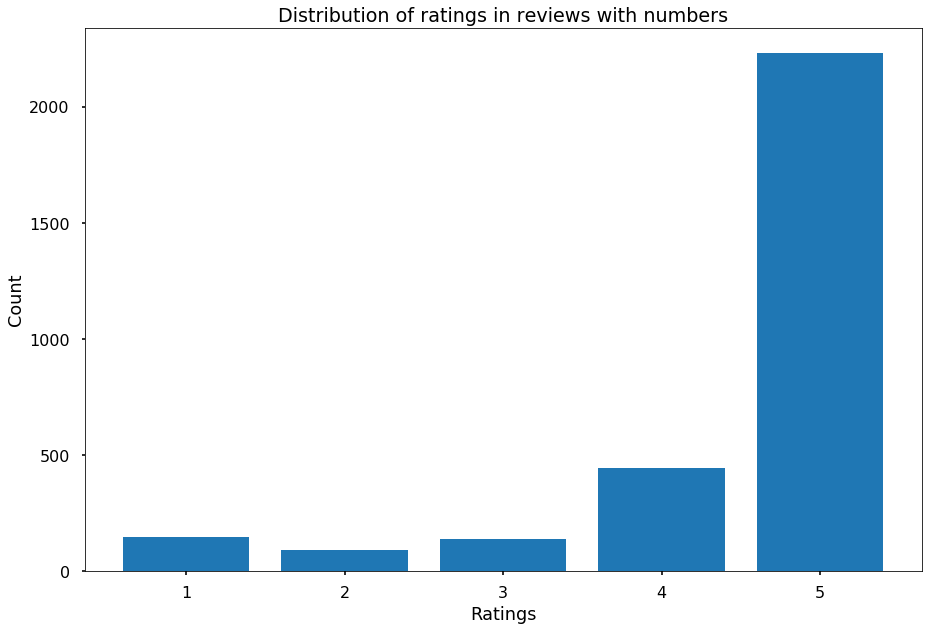

In [38]:
ratings, counts = np.unique(clean_data.rating, return_counts = True)
plt.figure(figsize = (15, 10))
plt.bar(ratings, counts)
plt.title("Distribution of ratings in reviews with numbers")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,rating
138,-0.044399,-0.065865,0.024451,-0.010592,0.058767,-0.030119,-0.039347,0.007076,-0.034220,0.067669,...,-0.082868,0.019262,0.067044,0.009602,-0.023819,-0.011730,-0.050108,-0.058509,0.022618,1
159,0.016404,-0.069984,0.015957,0.034067,-0.018448,-0.014565,0.003978,-0.063237,-0.022446,0.033150,...,0.024541,0.015214,0.064698,0.038953,-0.019555,0.018938,0.041147,0.021364,0.037249,1
334,-0.029376,-0.071797,0.049808,-0.016851,0.021807,0.083767,0.063255,-0.004403,-0.034141,-0.001317,...,-0.102068,-0.012657,-0.000068,-0.052601,-0.061142,-0.017420,-0.021905,0.002735,-0.017616,1
343,-0.065312,-0.061200,-0.028841,0.012732,-0.034578,0.034636,-0.000194,-0.071881,-0.001162,0.066499,...,0.016506,-0.003556,-0.023925,0.028012,0.023862,-0.026718,-0.025935,-0.043305,0.005890,1
354,-0.031175,-0.070770,-0.055644,0.055434,0.024926,-0.033304,-0.026112,0.013936,-0.031991,-0.086197,...,0.003886,-0.049898,0.010283,0.043167,-0.026171,-0.010999,-0.030818,-0.057349,0.017242,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,0.015488,-0.025546,-0.019644,0.056763,0.102121,-0.083804,0.021482,0.038399,0.011140,0.028189,...,0.007729,0.073470,0.033389,-0.048948,0.006730,-0.069147,0.065607,0.034081,0.008259,5
1541,-0.053224,-0.078224,0.023684,0.074374,-0.002662,-0.018746,-0.052799,0.024776,-0.059087,-0.088914,...,0.006571,-0.045545,-0.018815,-0.033398,0.046630,0.000512,-0.002194,0.040470,0.022094,5
2564,-0.019092,0.056368,-0.027476,0.007767,0.077385,-0.000200,0.049276,0.006659,0.003579,-0.003958,...,-0.048877,0.055919,-0.007854,-0.006072,-0.023072,0.024164,0.026280,0.069072,0.048256,5
941,0.007154,-0.058362,-0.053102,-0.033199,-0.035719,-0.069151,-0.050830,-0.063486,0.061213,0.056667,...,0.055518,-0.032929,0.028994,0.033650,0.046149,0.008884,-0.052608,0.062511,-0.011219,5


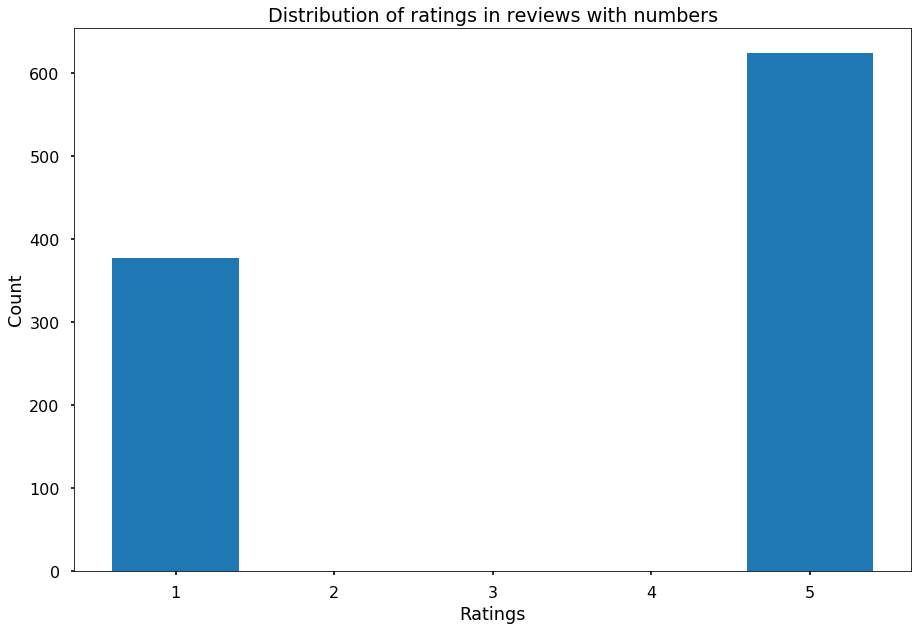

In [58]:
embeddings['rating'] = clean_data.rating.values

subsample2 = embeddings[embeddings['rating'] == 2]
subsample2['rating'] = 1

subsample3 = embeddings[embeddings['rating'] == 3]
subsample3['rating'] = 1

subsample1 = embeddings[embeddings['rating'] == 1]
subsample5 = embeddings[embeddings['rating'] == 5].sample(frac = 0.28, replace = True, random_state = SEED)

final = pd.concat([subsample1, subsample2, subsample3, subsample5])
display(final)

ratings, counts = np.unique(final.rating, return_counts = True)
plt.figure(figsize = (15, 10))
plt.bar(ratings, counts)
plt.title("Distribution of ratings in reviews with numbers")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

# Principal Component Anlysis for 3D visualization based on feedback

Explained variation per principal component: [0.08583275 0.04301734 0.03185496]


,Component One,Component Two,Component Three,Label
0,0.216378,-0.159115,-0.078127,1
1,-0.050416,0.084432,-0.193511,1
2,0.164016,-0.105224,-0.286344,1
3,-0.218491,0.084822,-0.248582,1
4,-0.164066,0.026062,-0.121187,1
...,...,...,...,...
996,0.143732,-0.390564,-0.043486,5
997,-0.165460,0.174155,-0.035625,5
998,0.054313,-0.252185,0.294939,5
999,-0.317130,0.178740,-0.053842,5


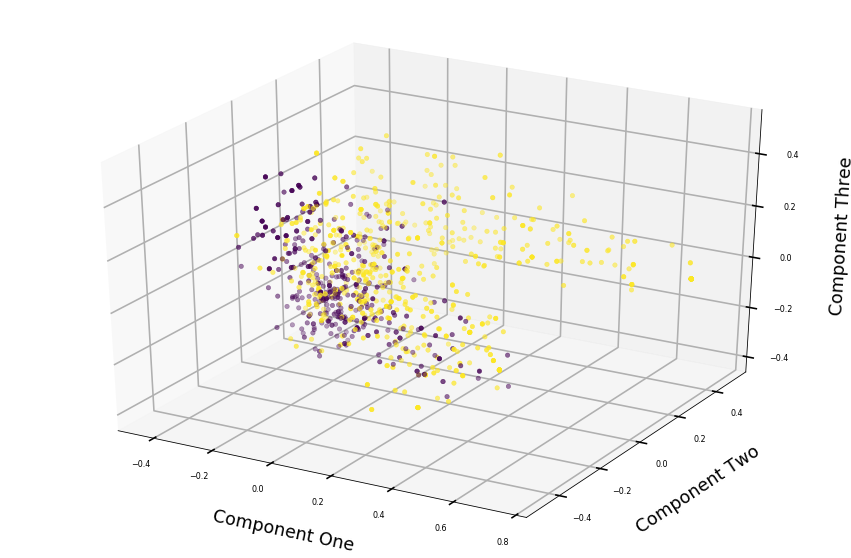

In [61]:
labels = final.rating.values
text   = final.drop(["rating"], axis = 1, inplace = False)

%matplotlib inline

pca = PCA(n_components = 3, random_state = SEED)
X   = pca.fit_transform(text)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

pca_data = pd.DataFrame(X, columns = ['Component One', 'Component Two', 'Component Three'])
pca_data["Label"] = labels

display(pca_data)

rndperm = np.random.permutation(pca_data.shape[0])

ax = plt.figure(figsize = (15, 10)).gca(projection = '3d')

ax.scatter(
    xs = pca_data.loc[rndperm,:]["Component One"], 
    ys = pca_data.loc[rndperm,:]["Component Two"], 
    zs = pca_data.loc[rndperm,:]["Component Three"], 
    c = pca_data.loc[rndperm,:]["Label"], 
    cmap = "viridis"
)

ax.set_xlabel('Component One',   labelpad = 30)
ax.set_ylabel('Component Two',   labelpad = 30)
ax.set_zlabel('Component Three', labelpad = 30)

ax.tick_params(axis = "x", labelsize = 8)
ax.tick_params(axis = "y", labelsize = 8)
ax.tick_params(axis = "z", labelsize = 8)
plt.savefig("pca_feedback.png")
plt.show();

# Clustering Baseline KMeans
The mapping from labels to clusters will be established on the validation and tested on the holdout set

In [41]:
labels = final.rating
text   = final.drop(["rating"], axis = 1, inplace = False)

X_train_valid, X_test, y_train_valid, y_test = train_test_split(text, labels, test_size = 0.1, random_state = SEED, stratify = labels)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.2, random_state = SEED, stratify = y_train_valid)

model = KMeans(n_clusters = 2, random_state = SEED)
model.fit(X_train)

for rating in [1, 5]:
    indices = y_valid[y_valid == rating].index
    grouped_reviews = X_valid.loc[indices].values
    print("Rating: {} with {} samples".format(rating, len(grouped_reviews)))
    predictions = model.predict(grouped_reviews)
    preds, count = np.unique(predictions, return_counts = True)
    print([(c, x) for (c, x) in reversed(sorted(zip(count, preds)))])
    
map_to_unsupervised = {
    1 : 0,
    5 : 1
}
    
labels = y_test.map(map_to_unsupervised)
predicted = model.predict(X_test)

print("Baseline Accuracy K-Means: {}, with random chance 50%".format(accuracy_score(labels, predicted)))

Rating: 1 with 68 samples
[(62, 0), (6, 1)]
Rating: 5 with 114 samples
[(61, 0), (53, 1)]
Baseline Accuracy K-Means: 0.6138613861386139, with random chance 50%


# Grid Search for KMeans on feedback labels

In [42]:
best_accuracy = 0
best_parameters = None

for pca_components in [None, 3, 10, 50, 100, 300]:
    for init in ['k-means++', 'random']:
        for n_init in [1, 2, 3, 5, 10, 30, 50, 100, 300]:
            for max_iter in [300, 500, 1000]:
                    
                    X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.2, random_state = SEED, stratify = y_train_valid)

                    if pca_components is not None:
                        pca = PCA(n_components = pca_components, random_state = SEED)
                        pca.fit(X_train)
                        X_train = pca.transform(X_train)
                        X_valid = pca.transform(X_valid)

                    model = KMeans(n_clusters = 2, init = init, n_init = n_init, max_iter = max_iter, random_state = SEED)
                    model.fit(X_train)

                    map_to_unsupervised = {
                        1 : 0,
                        5 : 1
                    }

                    labels = y_valid.map(map_to_unsupervised)
                    predicted = model.predict(X_valid)

                    accuracy = accuracy_score(labels, predicted)

                    print("Parameters: {}, {}, {}, {} with accuracy {}".format(pca_components, init, n_init, max_iter, accuracy))
                    if accuracy > best_accuracy:
                        print("Save new best")
                        best_accuracy = accuracy
                        best_parameters = (pca_components, init, n_init, max_iter)


Parameters: None, k-means++, 1, 300 with accuracy 0.6388888888888888
Save new best
Parameters: None, k-means++, 1, 500 with accuracy 0.6388888888888888
Parameters: None, k-means++, 1, 1000 with accuracy 0.6388888888888888
Parameters: None, k-means++, 2, 300 with accuracy 0.6388888888888888
Parameters: None, k-means++, 2, 500 with accuracy 0.6388888888888888
Parameters: None, k-means++, 2, 1000 with accuracy 0.6388888888888888
Parameters: None, k-means++, 3, 300 with accuracy 0.6388888888888888
Parameters: None, k-means++, 3, 500 with accuracy 0.6388888888888888
Parameters: None, k-means++, 3, 1000 with accuracy 0.6388888888888888
Parameters: None, k-means++, 5, 300 with accuracy 0.6388888888888888
Parameters: None, k-means++, 5, 500 with accuracy 0.6388888888888888
Parameters: None, k-means++, 5, 1000 with accuracy 0.6388888888888888
Parameters: None, k-means++, 10, 300 with accuracy 0.6388888888888888
Parameters: None, k-means++, 10, 500 with accuracy 0.6388888888888888
Parameters: No

Parameters: 10, k-means++, 50, 300 with accuracy 0.39444444444444443
Parameters: 10, k-means++, 50, 500 with accuracy 0.39444444444444443
Parameters: 10, k-means++, 50, 1000 with accuracy 0.39444444444444443
Parameters: 10, k-means++, 100, 300 with accuracy 0.39444444444444443
Parameters: 10, k-means++, 100, 500 with accuracy 0.39444444444444443
Parameters: 10, k-means++, 100, 1000 with accuracy 0.39444444444444443
Parameters: 10, k-means++, 300, 300 with accuracy 0.39444444444444443
Parameters: 10, k-means++, 300, 500 with accuracy 0.39444444444444443
Parameters: 10, k-means++, 300, 1000 with accuracy 0.39444444444444443
Parameters: 10, random, 1, 300 with accuracy 0.6333333333333333
Parameters: 10, random, 1, 500 with accuracy 0.6333333333333333
Parameters: 10, random, 1, 1000 with accuracy 0.6333333333333333
Parameters: 10, random, 2, 300 with accuracy 0.4111111111111111
Parameters: 10, random, 2, 500 with accuracy 0.4111111111111111
Parameters: 10, random, 2, 1000 with accuracy 0.4

Parameters: 100, random, 3, 1000 with accuracy 0.4111111111111111
Parameters: 100, random, 5, 300 with accuracy 0.4111111111111111
Parameters: 100, random, 5, 500 with accuracy 0.4111111111111111
Parameters: 100, random, 5, 1000 with accuracy 0.4111111111111111
Parameters: 100, random, 10, 300 with accuracy 0.4111111111111111
Parameters: 100, random, 10, 500 with accuracy 0.4111111111111111
Parameters: 100, random, 10, 1000 with accuracy 0.4111111111111111
Parameters: 100, random, 30, 300 with accuracy 0.37777777777777777
Parameters: 100, random, 30, 500 with accuracy 0.37777777777777777
Parameters: 100, random, 30, 1000 with accuracy 0.37777777777777777
Parameters: 100, random, 50, 300 with accuracy 0.37777777777777777
Parameters: 100, random, 50, 500 with accuracy 0.37777777777777777
Parameters: 100, random, 50, 1000 with accuracy 0.37777777777777777
Parameters: 100, random, 100, 300 with accuracy 0.6277777777777778
Parameters: 100, random, 100, 500 with accuracy 0.6277777777777778
P

# KMeans Final results on the feedback target

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.2, random_state = SEED, stratify = y_train_valid)

if best_parameters[0] is not None:
    pca = PCA(n_components = best_parameters[0], random_state = SEED)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_valid = pca.transform(X_valid)
    X_test  = pca.transform(X_test)

model = KMeans(n_clusters = 2, init = best_parameters[1], n_init = best_parameters[2], max_iter = best_parameters[3], random_state = SEED)
model.fit(X_train)

for rating in [1, 5]:
    indices = y_valid[y_valid == rating].index
    grouped_reviews = X_valid.loc[indices].values
    print("Rating: {} with {} samples".format(rating, len(grouped_reviews)))
    predictions = model.predict(grouped_reviews)
    preds, count = np.unique(predictions, return_counts = True)
    print([(c, x) for (c, x) in reversed(sorted(zip(count, preds)))])
    
map_to_unsupervised = {
    1 : 0,
    5 : 1
}
    
labels = y_test.map(map_to_unsupervised)
predicted = model.predict(X_test)

print("Final Accuracy K-Means: {}, with random chance 50%".format(accuracy_score(labels, predicted)))

Rating: 1 with 68 samples
[(62, 0), (6, 1)]
Rating: 5 with 114 samples
[(60, 0), (54, 1)]
Final Accuracy K-Means: 0.6138613861386139, with random chance 50%


# Gaussian Mixture Baseline Model on feedback 

In [44]:
labels = final.rating
text   = final.drop(["rating"], axis = 1, inplace = False)

X_train_valid, X_test, y_train_valid, y_test = train_test_split(text, labels, test_size = 0.1, random_state = SEED, stratify = labels)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.3, random_state = SEED, stratify = y_train_valid)

# weights = [0.12264150943396226, 0.8773584905660378]
# n_init = 1, max_iter = 1000, covariance_type = 'tied'

model = GaussianMixture(n_components = 2, random_state = SEED)
model.fit(X_train)

for rating in [1, 5]:
    indices = y_valid[y_valid == rating].index
    grouped_reviews = X_valid.loc[indices].values
    print("Rating: {} with {} samples".format(rating, len(grouped_reviews)))
    
    predictions = model.predict(grouped_reviews)
    
    preds, count = np.unique(predictions, return_counts = True)
    print([(c, x) for (c, x) in reversed(sorted(zip(count, preds)))])
    
    
map_to_unsupervised = {
    1 : 1,
    5 : 0
}

labels = y_test.map(map_to_unsupervised)
predicted = model.predict(X_test)

print("Baseline Accuracy Gaussian Mixture: {}, with random chance 50%".format(accuracy_score(labels, predicted)))

Rating: 1 with 102 samples
[(98, 1), (4, 0)]
Rating: 5 with 172 samples
[(126, 1), (46, 0)]
Baseline Accuracy Gaussian Mixture: 0.5346534653465347, with random chance 50%


# Grid Search for Gaussian Mixture on feedback

In [45]:
best_accuracy = 0
best_parameters = None

for pca_components in [None, 3, 10, 50, 100, 300]:
    for covariance_type in ['full', 'tied', 'diag', 'spherical']:
        for init in ['kmeans', 'random']:
            for n_init in [1, 2, 3, 5, 10]:
                for max_iter in [300, 500, 1000]:

                        X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.3, random_state = SEED, stratify = y_train_valid)

                        if pca_components is not None:
                            pca = PCA(n_components = pca_components, random_state = SEED)
                            pca.fit(X_train)
                            X_train = pca.transform(X_train)
                            X_valid = pca.transform(X_valid)

                        model = GaussianMixture(n_components = 2, init_params = init, n_init = n_init, covariance_type = covariance_type, max_iter = max_iter, random_state = SEED)
                        model.fit(X_train)

                        map_to_unsupervised = {
                            1 : 0,
                            5 : 1
                        }

                        labels = y_valid.map(map_to_unsupervised)
                        predicted = model.predict(X_valid)

                        accuracy = accuracy_score(labels, predicted)

                        print("Parameters: {}, {}, {}, {}, {} with accuracy {}".format(pca_components, init, n_init, covariance_type, max_iter, accuracy))
                        if accuracy > best_accuracy:
                            print("Save new best")
                            best_accuracy = accuracy
                            best_parameters = (pca_components, init, n_init, covariance_type, max_iter)


Parameters: None, kmeans, 1, full, 300 with accuracy 0.4666666666666667
Save new best
Parameters: None, kmeans, 1, full, 500 with accuracy 0.4666666666666667
Parameters: None, kmeans, 1, full, 1000 with accuracy 0.4666666666666667
Parameters: None, kmeans, 2, full, 300 with accuracy 0.4666666666666667
Parameters: None, kmeans, 2, full, 500 with accuracy 0.4666666666666667
Parameters: None, kmeans, 2, full, 1000 with accuracy 0.4666666666666667
Parameters: None, kmeans, 3, full, 300 with accuracy 0.4666666666666667
Parameters: None, kmeans, 3, full, 500 with accuracy 0.4666666666666667
Parameters: None, kmeans, 3, full, 1000 with accuracy 0.4666666666666667
Parameters: None, kmeans, 5, full, 300 with accuracy 0.4666666666666667
Parameters: None, kmeans, 5, full, 500 with accuracy 0.4666666666666667
Parameters: None, kmeans, 5, full, 1000 with accuracy 0.4666666666666667
Parameters: None, kmeans, 10, full, 300 with accuracy 0.4666666666666667
Parameters: None, kmeans, 10, full, 500 with 

Parameters: None, random, 3, spherical, 300 with accuracy 0.6111111111111112
Parameters: None, random, 3, spherical, 500 with accuracy 0.6111111111111112
Parameters: None, random, 3, spherical, 1000 with accuracy 0.6111111111111112
Parameters: None, random, 5, spherical, 300 with accuracy 0.6111111111111112
Parameters: None, random, 5, spherical, 500 with accuracy 0.6111111111111112
Parameters: None, random, 5, spherical, 1000 with accuracy 0.6111111111111112
Parameters: None, random, 10, spherical, 300 with accuracy 0.6111111111111112
Parameters: None, random, 10, spherical, 500 with accuracy 0.6111111111111112
Parameters: None, random, 10, spherical, 1000 with accuracy 0.6111111111111112
Parameters: 3, kmeans, 1, full, 300 with accuracy 0.6555555555555556
Save new best
Parameters: 3, kmeans, 1, full, 500 with accuracy 0.6555555555555556
Parameters: 3, kmeans, 1, full, 1000 with accuracy 0.6555555555555556
Parameters: 3, kmeans, 2, full, 300 with accuracy 0.6555555555555556
Parameters

Parameters: 3, random, 2, spherical, 300 with accuracy 0.34814814814814815
Parameters: 3, random, 2, spherical, 500 with accuracy 0.34814814814814815
Parameters: 3, random, 2, spherical, 1000 with accuracy 0.34814814814814815
Parameters: 3, random, 3, spherical, 300 with accuracy 0.6518518518518519
Parameters: 3, random, 3, spherical, 500 with accuracy 0.6518518518518519
Parameters: 3, random, 3, spherical, 1000 with accuracy 0.6518518518518519
Parameters: 3, random, 5, spherical, 300 with accuracy 0.34814814814814815
Parameters: 3, random, 5, spherical, 500 with accuracy 0.34814814814814815
Parameters: 3, random, 5, spherical, 1000 with accuracy 0.34814814814814815
Parameters: 3, random, 10, spherical, 300 with accuracy 0.34814814814814815
Parameters: 3, random, 10, spherical, 500 with accuracy 0.34814814814814815
Parameters: 3, random, 10, spherical, 1000 with accuracy 0.34814814814814815
Parameters: 10, kmeans, 1, full, 300 with accuracy 0.6518518518518519
Parameters: 10, kmeans, 1,

Parameters: 10, random, 1, spherical, 500 with accuracy 0.4074074074074074
Parameters: 10, random, 1, spherical, 1000 with accuracy 0.4074074074074074
Parameters: 10, random, 2, spherical, 300 with accuracy 0.4074074074074074
Parameters: 10, random, 2, spherical, 500 with accuracy 0.4074074074074074
Parameters: 10, random, 2, spherical, 1000 with accuracy 0.4074074074074074
Parameters: 10, random, 3, spherical, 300 with accuracy 0.5925925925925926
Parameters: 10, random, 3, spherical, 500 with accuracy 0.5925925925925926
Parameters: 10, random, 3, spherical, 1000 with accuracy 0.5925925925925926
Parameters: 10, random, 5, spherical, 300 with accuracy 0.5925925925925926
Parameters: 10, random, 5, spherical, 500 with accuracy 0.5925925925925926
Parameters: 10, random, 5, spherical, 1000 with accuracy 0.5925925925925926
Parameters: 10, random, 10, spherical, 300 with accuracy 0.5925925925925926
Parameters: 10, random, 10, spherical, 500 with accuracy 0.5925925925925926
Parameters: 10, ran

Parameters: 50, kmeans, 10, spherical, 500 with accuracy 0.6111111111111112
Parameters: 50, kmeans, 10, spherical, 1000 with accuracy 0.6111111111111112
Parameters: 50, random, 1, spherical, 300 with accuracy 0.3888888888888889
Parameters: 50, random, 1, spherical, 500 with accuracy 0.3888888888888889
Parameters: 50, random, 1, spherical, 1000 with accuracy 0.3888888888888889
Parameters: 50, random, 2, spherical, 300 with accuracy 0.3888888888888889
Parameters: 50, random, 2, spherical, 500 with accuracy 0.3888888888888889
Parameters: 50, random, 2, spherical, 1000 with accuracy 0.3888888888888889
Parameters: 50, random, 3, spherical, 300 with accuracy 0.3888888888888889
Parameters: 50, random, 3, spherical, 500 with accuracy 0.3888888888888889
Parameters: 50, random, 3, spherical, 1000 with accuracy 0.3888888888888889
Parameters: 50, random, 5, spherical, 300 with accuracy 0.3888888888888889
Parameters: 50, random, 5, spherical, 500 with accuracy 0.3888888888888889
Parameters: 50, ran

Parameters: 100, kmeans, 3, spherical, 300 with accuracy 0.6111111111111112
Parameters: 100, kmeans, 3, spherical, 500 with accuracy 0.6111111111111112
Parameters: 100, kmeans, 3, spherical, 1000 with accuracy 0.6111111111111112
Parameters: 100, kmeans, 5, spherical, 300 with accuracy 0.3888888888888889
Parameters: 100, kmeans, 5, spherical, 500 with accuracy 0.3888888888888889
Parameters: 100, kmeans, 5, spherical, 1000 with accuracy 0.3888888888888889
Parameters: 100, kmeans, 10, spherical, 300 with accuracy 0.3888888888888889
Parameters: 100, kmeans, 10, spherical, 500 with accuracy 0.3888888888888889
Parameters: 100, kmeans, 10, spherical, 1000 with accuracy 0.3888888888888889
Parameters: 100, random, 1, spherical, 300 with accuracy 0.3888888888888889
Parameters: 100, random, 1, spherical, 500 with accuracy 0.3888888888888889
Parameters: 100, random, 1, spherical, 1000 with accuracy 0.3888888888888889
Parameters: 100, random, 2, spherical, 300 with accuracy 0.3888888888888889
Param

Parameters: 300, random, 10, diag, 1000 with accuracy 0.4666666666666667
Parameters: 300, kmeans, 1, spherical, 300 with accuracy 0.3888888888888889
Parameters: 300, kmeans, 1, spherical, 500 with accuracy 0.3888888888888889
Parameters: 300, kmeans, 1, spherical, 1000 with accuracy 0.3888888888888889
Parameters: 300, kmeans, 2, spherical, 300 with accuracy 0.6111111111111112
Parameters: 300, kmeans, 2, spherical, 500 with accuracy 0.6111111111111112
Parameters: 300, kmeans, 2, spherical, 1000 with accuracy 0.6111111111111112
Parameters: 300, kmeans, 3, spherical, 300 with accuracy 0.6111111111111112
Parameters: 300, kmeans, 3, spherical, 500 with accuracy 0.6111111111111112
Parameters: 300, kmeans, 3, spherical, 1000 with accuracy 0.6111111111111112
Parameters: 300, kmeans, 5, spherical, 300 with accuracy 0.6111111111111112
Parameters: 300, kmeans, 5, spherical, 500 with accuracy 0.6111111111111112
Parameters: 300, kmeans, 5, spherical, 1000 with accuracy 0.6111111111111112
Parameters:

In [46]:
labels = final.rating
text   = final.drop(["rating"], axis = 1, inplace = False)

X_train_valid, X_test, y_train_valid, y_test = train_test_split(text, labels, test_size = 0.1, random_state = SEED, stratify = labels)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.3, random_state = SEED, stratify = y_train_valid)

if best_parameters[0] is not None:
    pca = PCA(n_components = best_parameters[0], random_state = SEED)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test  = pca.transform(X_test)

model = GaussianMixture(n_components = 2, init_params = best_parameters[1], n_init = best_parameters[2], covariance_type = best_parameters[3], max_iter = best_parameters[4], random_state = SEED)
model.fit(X_train)

for rating in [1, 5]:
    indices = y_valid[y_valid == rating].index
    grouped_reviews = X_valid.loc[indices].values
    
    if best_parameters[0] is not None:
        grouped_reviews = pca.transform(grouped_reviews)
        
    print("Rating: {} with {} samples".format(rating, len(grouped_reviews)))
    predictions = model.predict(grouped_reviews)
    preds, count = np.unique(predictions, return_counts = True)
    print([(c, x) for (c, x) in reversed(sorted(zip(count, preds)))])
    
map_to_unsupervised = {
    1 : 0,
    5 : 1
}
    
labels = y_test.map(map_to_unsupervised)
predicted = model.predict(X_test)

print("Final Accuracy Gaussian Mixture: {}, with random chance 50%".format(accuracy_score(labels, predicted)))

Rating: 1 with 102 samples
[(54, 0), (48, 1)]
Rating: 5 with 172 samples
[(131, 1), (41, 0)]
Final Accuracy Gaussian Mixture: 0.7128712871287128, with random chance 50%


# Supervised Model Baseline on Feedback 

In [47]:
labels = final.rating
text   = final.drop(["rating"], axis = 1, inplace = False)

X_train_valid, X_test, y_train_valid, y_test = train_test_split(text, labels, test_size = 0.1, random_state = SEED, stratify = labels)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.3, random_state = SEED, stratify = y_train_valid)

model = LogisticRegression(random_state = SEED, n_jobs = N_JOBS)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Logistic Regression Accuracy: {}".format(accuracy_score(y_test, predictions)))

Logistic Regression Accuracy: 0.9108910891089109


# Going to a harder problem, clustering based on rating from 1 to 5
- This will be a much more difficult problem to solve because of reviews inconsistency, but will try work this out
- The main baseline here will be the random chance, in this case 20%

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,rating
6,-0.038224,0.042605,-0.020850,0.019281,0.060642,0.003497,0.003771,-0.058655,-0.015380,-0.012263,...,-0.018652,-0.057831,-0.058919,0.035694,0.040967,0.032326,0.015002,0.007083,0.041510,3
24,-0.018971,-0.058152,-0.020863,-0.022801,-0.036309,0.080219,-0.039726,0.027269,-0.005818,0.034189,...,-0.048405,-0.059264,0.026940,-0.002860,0.025261,0.078405,0.038489,-0.005936,0.070342,3
32,-0.028690,-0.082877,0.086156,0.057692,0.075252,0.005372,-0.035588,-0.028507,0.041523,-0.051719,...,-0.028222,-0.050131,0.045512,-0.071631,0.012697,-0.019395,0.025447,-0.018311,0.039398,3
45,0.000053,-0.071633,-0.043183,-0.030963,0.063479,-0.074514,0.041473,-0.065921,0.065841,-0.030991,...,-0.030025,0.031656,0.028113,0.054150,-0.065755,-0.005555,-0.022990,0.052102,0.025341,2
48,-0.048423,-0.022823,0.084106,0.065420,0.021314,-0.060736,-0.042238,-0.009468,0.059519,-0.067186,...,-0.008756,-0.023617,-0.006265,-0.056337,0.043017,-0.016015,-0.012120,-0.042134,0.023311,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,0.057699,-0.019225,0.022019,-0.068246,0.047815,0.012552,0.009404,0.020274,0.018854,0.014760,...,-0.003233,-0.004147,0.048390,0.012192,-0.000147,-0.012681,-0.082792,-0.023648,-0.001027,5
418,0.046802,-0.009405,0.012567,-0.052717,-0.073809,-0.011522,-0.061130,-0.009273,0.040517,0.032716,...,-0.079631,0.028659,0.035872,-0.015064,-0.008169,-0.002511,-0.066775,-0.015725,-0.012450,5
1997,0.085492,0.014358,0.092100,-0.002732,-0.046216,-0.009083,-0.027975,0.007420,-0.034613,0.006025,...,0.059277,0.009367,0.007002,0.010610,0.054107,0.039738,-0.053572,-0.005877,0.062246,5
318,0.013735,-0.004679,-0.063330,-0.008004,0.010292,0.038559,0.052826,-0.020833,0.043207,0.039066,...,-0.020722,-0.018764,0.027202,-0.081084,-0.040125,-0.012141,0.020329,-0.047197,0.035588,5


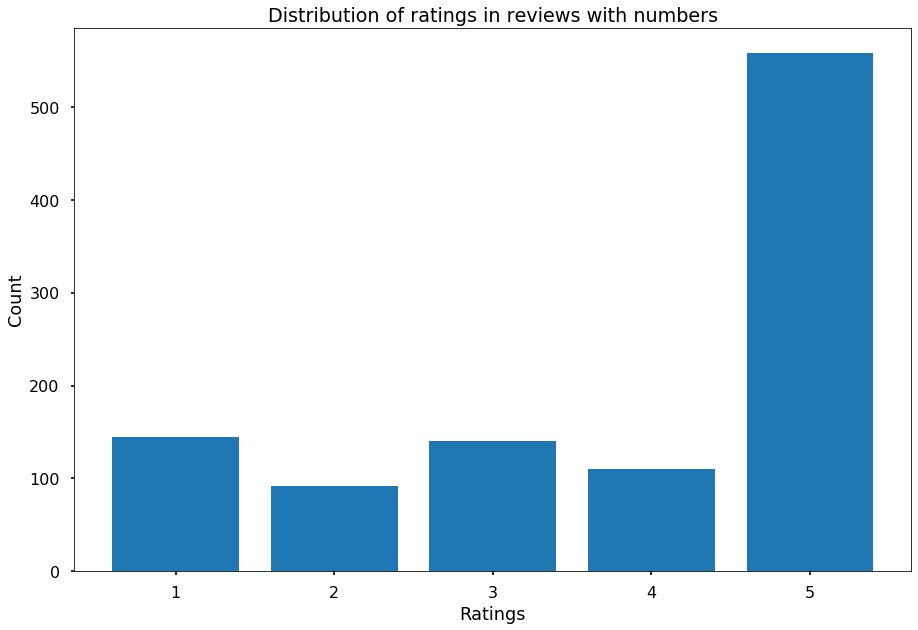

In [63]:
embeddings['rating'] = clean_data.rating.values
selected = embeddings[(embeddings['rating'] != 5) & (embeddings['rating'] != 4)]

subsample4 = embeddings[embeddings['rating'] == 4].sample(frac = 0.25, replace = True, random_state = SEED) 
subsample5 = embeddings[embeddings['rating'] == 5].sample(frac = 0.25, replace = True, random_state = SEED)

final = pd.concat([selected, subsample4, subsample5])
display(final)

ratings, counts = np.unique(final.rating, return_counts = True)
plt.figure(figsize = (15, 10))
plt.bar(ratings, counts)
plt.title("Distribution of ratings in reviews with numbers")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

# Principal Component Anlysis for 3D visualization based on ratings

Explained variation per principal component: [0.0830149  0.04259253 0.03272451]


,Component One,Component Two,Component Three,Label
0,-0.367978,-0.148789,0.098710,3
1,-0.172961,0.188515,0.104557,3
2,-0.287870,-0.005389,0.214779,3
3,-0.252204,0.024713,-0.021785,2
4,-0.181418,-0.226526,0.094741,3
...,...,...,...,...
1040,0.495834,-0.209884,0.225176,5
1041,0.464283,-0.273016,0.141296,5
1042,0.022373,-0.438479,0.337581,5
1043,-0.244166,-0.045575,-0.108478,5


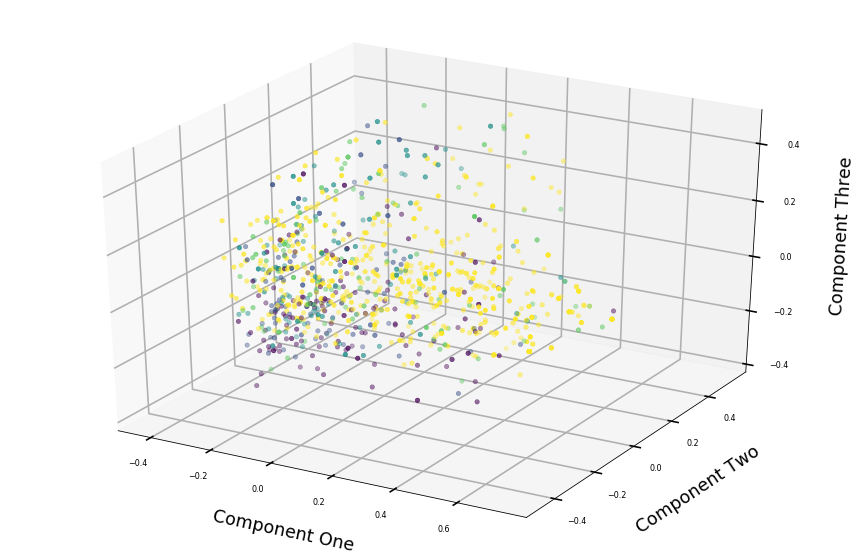

In [64]:
labels = final.rating.values
text   = final.drop(["rating"], axis = 1, inplace = False)

%matplotlib inline

pca = PCA(n_components = 3, random_state = SEED)
X   = pca.fit_transform(text)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

pca_data = pd.DataFrame(X, columns = ['Component One', 'Component Two', 'Component Three'])
pca_data["Label"] = labels

display(pca_data)

rndperm = np.random.permutation(pca_data.shape[0])

ax = plt.figure(figsize = (15, 10)).gca(projection = '3d')

ax.scatter(
    xs = pca_data.loc[rndperm,:]["Component One"], 
    ys = pca_data.loc[rndperm,:]["Component Two"], 
    zs = pca_data.loc[rndperm,:]["Component Three"], 
    c = pca_data.loc[rndperm,:]["Label"], 
    cmap = "viridis"
)

ax.set_xlabel('Component One',   labelpad = 30)
ax.set_ylabel('Component Two',   labelpad = 30)
ax.set_zlabel('Component Three', labelpad = 30)

ax.tick_params(axis = "x", labelsize = 8)
ax.tick_params(axis = "y", labelsize = 8)
ax.tick_params(axis = "z", labelsize = 8)

plt.savefig("pca_rating.png")
plt.show();


# Very overlapped clusters
- As you can see above the datasets are not separable but we can still observe the points going from a darker black to a bright orange or yellow
- Maybe with more dimensions things will change

# KMeans for clustering based on ratings

In [50]:
labels = final.rating
text   = final.drop(["rating"], axis = 1, inplace = False)

X_train_valid, X_test, y_train_valid, y_test = train_test_split(text, labels, test_size = 0.1, random_state = SEED, stratify = labels)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.3, random_state = SEED, stratify = y_train_valid)

# n_init = 10,
model = KMeans(n_clusters = 5, random_state = SEED)
model.fit(X_train)

for rating in [1, 2, 3, 4, 5]:
    indices = y_valid[y_valid == rating].index
    grouped_reviews = X_valid.loc[indices].values
    print("Rating: {} with {} samples".format(rating, len(predictions)))
    predictions = model.predict(grouped_reviews)
    preds, count = np.unique(predictions, return_counts = True)
    print([(c, x) for (c, x) in reversed(sorted(zip(count, preds)))])
    

map_to_unsupervised = {
    1 : 2,
    2 : 4,
    3 : 1,
    4 : 0,
    5 : 3
}
    
    
labels = y_test.map(map_to_unsupervised)
predicted = model.predict(X_test)

print("Baseline KMeans Accuracy {}".format(accuracy_score(labels, predicted)))

Rating: 1 with 101 samples
[(18, 0), (11, 3), (6, 1), (4, 2)]
Rating: 2 with 39 samples
[(11, 0), (7, 3), (6, 1), (1, 2)]
Rating: 3 with 25 samples
[(21, 0), (8, 3), (8, 1), (1, 2)]
Rating: 4 with 38 samples
[(23, 0), (6, 3), (4, 1), (2, 2), (1, 4)]
Rating: 5 with 36 samples
[(62, 3), (31, 0), (24, 4), (24, 2), (13, 1)]
Baseline KMeans Accuracy 0.3238095238095238


In [51]:
best_accuracy = 0
best_parameters = None

for pca_components in [None, 3, 10, 50, 100, 300]:
    for init in ['k-means++', 'random']:
        for n_init in [1, 2, 3, 5, 10, 30, 50, 100, 300]:
            for max_iter in [300, 500, 1000]:
                    
                    X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.3, random_state = SEED, stratify = y_train_valid)

                    if pca_components is not None:
                        pca = PCA(n_components = pca_components, random_state = SEED)
                        pca.fit(X_train)
                        X_train = pca.transform(X_train)
                        X_valid = pca.transform(X_valid)

                    model = KMeans(n_clusters = 5, init = init, n_init = n_init, max_iter = max_iter, random_state = SEED)
                    model.fit(X_train)

                    map_to_unsupervised = {
                        1 : 2,
                        2 : 4,
                        3 : 1,
                        4 : 0,
                        5 : 3
                    }
    
                    labels = y_valid.map(map_to_unsupervised)
                    predicted = model.predict(X_valid)

                    accuracy = accuracy_score(labels, predicted)

                    print("Parameters: {}, {}, {}, {} with accuracy {}".format(pca_components, init, n_init, max_iter, accuracy))
                    if accuracy > best_accuracy:
                        print("Save new best")
                        best_accuracy = accuracy
                        best_parameters = (pca_components, init, n_init, max_iter)

Parameters: None, k-means++, 1, 300 with accuracy 0.2730496453900709
Save new best
Parameters: None, k-means++, 1, 500 with accuracy 0.2730496453900709
Parameters: None, k-means++, 1, 1000 with accuracy 0.2730496453900709
Parameters: None, k-means++, 2, 300 with accuracy 0.2730496453900709
Parameters: None, k-means++, 2, 500 with accuracy 0.2730496453900709
Parameters: None, k-means++, 2, 1000 with accuracy 0.2730496453900709
Parameters: None, k-means++, 3, 300 with accuracy 0.18439716312056736
Parameters: None, k-means++, 3, 500 with accuracy 0.18439716312056736
Parameters: None, k-means++, 3, 1000 with accuracy 0.18439716312056736
Parameters: None, k-means++, 5, 300 with accuracy 0.31560283687943264
Save new best
Parameters: None, k-means++, 5, 500 with accuracy 0.31560283687943264
Parameters: None, k-means++, 5, 1000 with accuracy 0.31560283687943264
Parameters: None, k-means++, 10, 300 with accuracy 0.31560283687943264
Parameters: None, k-means++, 10, 500 with accuracy 0.3156028368

Parameters: 10, k-means++, 10, 500 with accuracy 0.16666666666666666
Parameters: 10, k-means++, 10, 1000 with accuracy 0.16666666666666666
Parameters: 10, k-means++, 30, 300 with accuracy 0.16666666666666666
Parameters: 10, k-means++, 30, 500 with accuracy 0.16666666666666666
Parameters: 10, k-means++, 30, 1000 with accuracy 0.16666666666666666
Parameters: 10, k-means++, 50, 300 with accuracy 0.16666666666666666
Parameters: 10, k-means++, 50, 500 with accuracy 0.16666666666666666
Parameters: 10, k-means++, 50, 1000 with accuracy 0.16666666666666666
Parameters: 10, k-means++, 100, 300 with accuracy 0.30141843971631205
Parameters: 10, k-means++, 100, 500 with accuracy 0.30141843971631205
Parameters: 10, k-means++, 100, 1000 with accuracy 0.30141843971631205
Parameters: 10, k-means++, 300, 300 with accuracy 0.1453900709219858
Parameters: 10, k-means++, 300, 500 with accuracy 0.1453900709219858
Parameters: 10, k-means++, 300, 1000 with accuracy 0.1453900709219858
Parameters: 10, random, 1,

Parameters: 100, k-means++, 300, 1000 with accuracy 0.20921985815602837
Parameters: 100, random, 1, 300 with accuracy 0.1347517730496454
Parameters: 100, random, 1, 500 with accuracy 0.1347517730496454
Parameters: 100, random, 1, 1000 with accuracy 0.1347517730496454
Parameters: 100, random, 2, 300 with accuracy 0.1347517730496454
Parameters: 100, random, 2, 500 with accuracy 0.1347517730496454
Parameters: 100, random, 2, 1000 with accuracy 0.1347517730496454
Parameters: 100, random, 3, 300 with accuracy 0.1347517730496454
Parameters: 100, random, 3, 500 with accuracy 0.1347517730496454
Parameters: 100, random, 3, 1000 with accuracy 0.1347517730496454
Parameters: 100, random, 5, 300 with accuracy 0.1347517730496454
Parameters: 100, random, 5, 500 with accuracy 0.1347517730496454
Parameters: 100, random, 5, 1000 with accuracy 0.1347517730496454
Parameters: 100, random, 10, 300 with accuracy 0.13829787234042554
Parameters: 100, random, 10, 500 with accuracy 0.13829787234042554
Parameters

In [52]:
labels = final.rating
text   = final.drop(["rating"], axis = 1, inplace = False)

X_train_valid, X_test, y_train_valid, y_test = train_test_split(text, labels, test_size = 0.1, random_state = SEED, stratify = labels)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.3, random_state = SEED, stratify = y_train_valid)

if best_parameters[0] is not None:
    pca = PCA(n_components = best_parameters[0], random_state = SEED)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test  = pca.transform(X_test)

model = KMeans(n_clusters = 5, init = best_parameters[1], n_init = best_parameters[2], max_iter = best_parameters[3], random_state = SEED)
model.fit(X_train)

for rating in [1, 2, 3, 4, 5]:
    indices = y_valid[y_valid == rating].index
    grouped_reviews = X_valid.loc[indices].values
    
    if best_parameters[0] is not None:
        grouped_reviews = pca.transform(grouped_reviews)
        
    print("Rating: {} with {} samples".format(rating, len(grouped_reviews)))
    predictions = model.predict(grouped_reviews)
    preds, count = np.unique(predictions, return_counts = True)
    print([(c, x) for (c, x) in reversed(sorted(zip(count, preds)))])
    
map_to_unsupervised = {
    1 : 0,
    2 : 1,
    3 : 4,
    4 : 2,
    5 : 3
}
    
labels = y_test.map(map_to_unsupervised)
predicted = model.predict(X_test)

print("Final Accuracy K-Means: {}, with random chance 20%".format(accuracy_score(labels, predicted)))

Rating: 1 with 39 samples
[(19, 2), (10, 3), (6, 4), (4, 0)]
Rating: 2 with 25 samples
[(12, 2), (7, 4), (5, 3), (1, 0)]
Rating: 3 with 38 samples
[(20, 2), (9, 4), (8, 3), (1, 0)]
Rating: 4 with 36 samples
[(22, 2), (6, 3), (5, 4), (2, 0), (1, 1)]
Rating: 5 with 154 samples
[(73, 3), (25, 0), (24, 1), (23, 2), (9, 4)]
Final Accuracy K-Means: 0.34285714285714286, with random chance 20%


# Gaussian Mixture for clustering based on ratings

In [53]:
labels = final.rating
text   = final.drop(["rating"], axis = 1, inplace = False)

X_train_valid, X_test, y_train_valid, y_test = train_test_split(text, labels, test_size = 0.1, random_state = SEED, stratify = labels)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.4, random_state = SEED, stratify = y_train_valid)

# n_init = 10, covariance_type = 'diag', 
model = GaussianMixture(n_components = 5, random_state = SEED)
model.fit(X_train)

for rating in [1, 2, 3, 4, 5]:
    indices = y_valid[y_valid == rating].index
    grouped_reviews = X_valid.loc[indices].values
    
    print("Rating: {} with {} samples".format(rating, len(predictions)))
    predictions = model.predict(grouped_reviews)
    preds, count = np.unique(predictions, return_counts = True)
    print([(c, x) for (c, x) in reversed(sorted(zip(count, preds)))])

map_to_unsupervised = {
    1 : 2,
    2 : 3,
    3 : 0,
    4 : 4,
    5 : 1
}
    
labels = y_test.map(map_to_unsupervised)
predicted = model.predict(X_test)

print("Gaussian Mixture Accuracy {}".format(accuracy_score(labels, predicted)))

Rating: 1 with 154 samples
[(35, 3), (9, 2), (4, 4), (3, 1), (1, 0)]
Rating: 2 with 52 samples
[(28, 3), (3, 4), (2, 2)]
Rating: 3 with 33 samples
[(33, 3), (10, 4), (5, 2), (1, 1), (1, 0)]
Rating: 4 with 50 samples
[(32, 3), (5, 4), (5, 2), (4, 1)]
Rating: 5 with 46 samples
[(92, 3), (44, 2), (39, 1), (31, 4), (5, 0)]
Gaussian Mixture Accuracy 0.20952380952380953


In [54]:
best_accuracy = 0
best_parameters = None

for pca_components in [None, 3, 10, 50, 100, 300]:
    for covariance_type in ['full', 'tied', 'diag', 'spherical']:
        for init in ['kmeans', 'random']:
            for n_init in [1, 2, 3, 5, 10]:
                for max_iter in [300, 500, 1000]:

                        X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.4, random_state = SEED, stratify = y_train_valid)

                        if pca_components is not None:
                            pca = PCA(n_components = pca_components, random_state = SEED)
                            pca.fit(X_train)
                            X_train = pca.transform(X_train)
                            X_valid = pca.transform(X_valid)

                        model = GaussianMixture(n_components = 5, init_params = init, n_init = n_init, covariance_type = covariance_type, max_iter = max_iter, random_state = SEED)
                        model.fit(X_train)

                        map_to_unsupervised = {
                            1 : 2,
                            2 : 3,
                            3 : 0,
                            4 : 4,
                            5 : 1
                        }

                        labels = y_valid.map(map_to_unsupervised)
                        predicted = model.predict(X_valid)

                        accuracy = accuracy_score(labels, predicted)

                        print("Parameters: {}, {}, {}, {}, {} with accuracy {}".format(pca_components, init, n_init, covariance_type, max_iter, accuracy))
                        if accuracy > best_accuracy:
                            print("Save new best")
                            best_accuracy = accuracy
                            best_parameters = (pca_components, init, n_init, covariance_type, max_iter)


Parameters: None, kmeans, 1, full, 300 with accuracy 0.2127659574468085
Save new best
Parameters: None, kmeans, 1, full, 500 with accuracy 0.2127659574468085
Parameters: None, kmeans, 1, full, 1000 with accuracy 0.2127659574468085
Parameters: None, kmeans, 2, full, 300 with accuracy 0.2127659574468085
Parameters: None, kmeans, 2, full, 500 with accuracy 0.2127659574468085
Parameters: None, kmeans, 2, full, 1000 with accuracy 0.2127659574468085
Parameters: None, kmeans, 3, full, 300 with accuracy 0.2127659574468085
Parameters: None, kmeans, 3, full, 500 with accuracy 0.2127659574468085
Parameters: None, kmeans, 3, full, 1000 with accuracy 0.2127659574468085
Parameters: None, kmeans, 5, full, 300 with accuracy 0.2127659574468085
Parameters: None, kmeans, 5, full, 500 with accuracy 0.2127659574468085
Parameters: None, kmeans, 5, full, 1000 with accuracy 0.2127659574468085
Parameters: None, kmeans, 10, full, 300 with accuracy 0.1622340425531915
Parameters: None, kmeans, 10, full, 500 with 

Parameters: None, random, 3, spherical, 300 with accuracy 0.1595744680851064
Parameters: None, random, 3, spherical, 500 with accuracy 0.1595744680851064
Parameters: None, random, 3, spherical, 1000 with accuracy 0.1595744680851064
Parameters: None, random, 5, spherical, 300 with accuracy 0.1595744680851064
Parameters: None, random, 5, spherical, 500 with accuracy 0.1595744680851064
Parameters: None, random, 5, spherical, 1000 with accuracy 0.1595744680851064
Parameters: None, random, 10, spherical, 300 with accuracy 0.1595744680851064
Parameters: None, random, 10, spherical, 500 with accuracy 0.1595744680851064
Parameters: None, random, 10, spherical, 1000 with accuracy 0.1595744680851064
Parameters: 3, kmeans, 1, full, 300 with accuracy 0.21808510638297873
Parameters: 3, kmeans, 1, full, 500 with accuracy 0.21808510638297873
Parameters: 3, kmeans, 1, full, 1000 with accuracy 0.21808510638297873
Parameters: 3, kmeans, 2, full, 300 with accuracy 0.21808510638297873
Parameters: 3, kmean

Parameters: 3, random, 1, spherical, 1000 with accuracy 0.13031914893617022
Parameters: 3, random, 2, spherical, 300 with accuracy 0.2765957446808511
Parameters: 3, random, 2, spherical, 500 with accuracy 0.2765957446808511
Parameters: 3, random, 2, spherical, 1000 with accuracy 0.2765957446808511
Parameters: 3, random, 3, spherical, 300 with accuracy 0.2765957446808511
Parameters: 3, random, 3, spherical, 500 with accuracy 0.2765957446808511
Parameters: 3, random, 3, spherical, 1000 with accuracy 0.2765957446808511
Parameters: 3, random, 5, spherical, 300 with accuracy 0.16489361702127658
Parameters: 3, random, 5, spherical, 500 with accuracy 0.16489361702127658
Parameters: 3, random, 5, spherical, 1000 with accuracy 0.16489361702127658
Parameters: 3, random, 10, spherical, 300 with accuracy 0.13829787234042554
Parameters: 3, random, 10, spherical, 500 with accuracy 0.13829787234042554
Parameters: 3, random, 10, spherical, 1000 with accuracy 0.13829787234042554
Parameters: 10, kmeans,

Parameters: 10, kmeans, 10, spherical, 300 with accuracy 0.11702127659574468
Parameters: 10, kmeans, 10, spherical, 500 with accuracy 0.11702127659574468
Parameters: 10, kmeans, 10, spherical, 1000 with accuracy 0.11702127659574468
Parameters: 10, random, 1, spherical, 300 with accuracy 0.3377659574468085
Parameters: 10, random, 1, spherical, 500 with accuracy 0.3377659574468085
Parameters: 10, random, 1, spherical, 1000 with accuracy 0.3377659574468085
Parameters: 10, random, 2, spherical, 300 with accuracy 0.14627659574468085
Parameters: 10, random, 2, spherical, 500 with accuracy 0.14627659574468085
Parameters: 10, random, 2, spherical, 1000 with accuracy 0.14627659574468085
Parameters: 10, random, 3, spherical, 300 with accuracy 0.14627659574468085
Parameters: 10, random, 3, spherical, 500 with accuracy 0.14627659574468085
Parameters: 10, random, 3, spherical, 1000 with accuracy 0.14627659574468085
Parameters: 10, random, 5, spherical, 300 with accuracy 0.14627659574468085
Paramete

Parameters: 50, kmeans, 3, spherical, 300 with accuracy 0.2154255319148936
Parameters: 50, kmeans, 3, spherical, 500 with accuracy 0.2154255319148936
Parameters: 50, kmeans, 3, spherical, 1000 with accuracy 0.2154255319148936
Parameters: 50, kmeans, 5, spherical, 300 with accuracy 0.14361702127659576
Parameters: 50, kmeans, 5, spherical, 500 with accuracy 0.14361702127659576
Parameters: 50, kmeans, 5, spherical, 1000 with accuracy 0.14361702127659576
Parameters: 50, kmeans, 10, spherical, 300 with accuracy 0.14893617021276595
Parameters: 50, kmeans, 10, spherical, 500 with accuracy 0.14893617021276595
Parameters: 50, kmeans, 10, spherical, 1000 with accuracy 0.14893617021276595
Parameters: 50, random, 1, spherical, 300 with accuracy 0.3670212765957447
Parameters: 50, random, 1, spherical, 500 with accuracy 0.3670212765957447
Parameters: 50, random, 1, spherical, 1000 with accuracy 0.3670212765957447
Parameters: 50, random, 2, spherical, 300 with accuracy 0.3670212765957447
Parameters: 

Parameters: 100, random, 10, diag, 500 with accuracy 0.15691489361702127
Parameters: 100, random, 10, diag, 1000 with accuracy 0.15691489361702127
Parameters: 100, kmeans, 1, spherical, 300 with accuracy 0.15159574468085107
Parameters: 100, kmeans, 1, spherical, 500 with accuracy 0.15159574468085107
Parameters: 100, kmeans, 1, spherical, 1000 with accuracy 0.15159574468085107
Parameters: 100, kmeans, 2, spherical, 300 with accuracy 0.15159574468085107
Parameters: 100, kmeans, 2, spherical, 500 with accuracy 0.15159574468085107
Parameters: 100, kmeans, 2, spherical, 1000 with accuracy 0.15159574468085107
Parameters: 100, kmeans, 3, spherical, 300 with accuracy 0.15159574468085107
Parameters: 100, kmeans, 3, spherical, 500 with accuracy 0.15159574468085107
Parameters: 100, kmeans, 3, spherical, 1000 with accuracy 0.15159574468085107
Parameters: 100, kmeans, 5, spherical, 300 with accuracy 0.21010638297872342
Parameters: 100, kmeans, 5, spherical, 500 with accuracy 0.21010638297872342
Par

Parameters: 300, random, 2, diag, 1000 with accuracy 0.15425531914893617
Parameters: 300, random, 3, diag, 300 with accuracy 0.15425531914893617
Parameters: 300, random, 3, diag, 500 with accuracy 0.15425531914893617
Parameters: 300, random, 3, diag, 1000 with accuracy 0.15425531914893617
Parameters: 300, random, 5, diag, 300 with accuracy 0.15425531914893617
Parameters: 300, random, 5, diag, 500 with accuracy 0.15425531914893617
Parameters: 300, random, 5, diag, 1000 with accuracy 0.15425531914893617
Parameters: 300, random, 10, diag, 300 with accuracy 0.15691489361702127
Parameters: 300, random, 10, diag, 500 with accuracy 0.15691489361702127
Parameters: 300, random, 10, diag, 1000 with accuracy 0.15691489361702127
Parameters: 300, kmeans, 1, spherical, 300 with accuracy 0.19680851063829788
Parameters: 300, kmeans, 1, spherical, 500 with accuracy 0.19680851063829788
Parameters: 300, kmeans, 1, spherical, 1000 with accuracy 0.19680851063829788
Parameters: 300, kmeans, 2, spherical, 30

In [55]:
labels = final.rating
text   = final.drop(["rating"], axis = 1, inplace = False)

X_train_valid, X_test, y_train_valid, y_test = train_test_split(text, labels, test_size = 0.1, random_state = SEED, stratify = labels)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.4, random_state = SEED, stratify = y_train_valid)

if best_parameters[0] is not None:
    pca = PCA(n_components = best_parameters[0], random_state = SEED)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test  = pca.transform(X_test)

model = GaussianMixture(n_components = 5, init_params = best_parameters[1], n_init = best_parameters[2], covariance_type = best_parameters[3], max_iter = best_parameters[4], random_state = SEED)
model.fit(X_train)

for rating in [1, 2, 3, 4, 5]:
    indices = y_valid[y_valid == rating].index
    grouped_reviews = X_valid.loc[indices].values
    
    if best_parameters[0] is not None:
        grouped_reviews = pca.transform(grouped_reviews)
        
    print("Rating: {} with {} samples".format(rating, len(grouped_reviews)))
    predictions = model.predict(grouped_reviews)
    preds, count = np.unique(predictions, return_counts = True)
    print([(c, x) for (c, x) in reversed(sorted(zip(count, preds)))])
    
map_to_unsupervised = {
    1 : 2,
    2 : 3,
    3 : 0,
    4 : 4,
    5 : 1
}
    
labels = y_test.map(map_to_unsupervised)
predicted = model.predict(X_test)

print("Final Accuracy Gaussian Mixture: {}, with random chance 20%".format(accuracy_score(labels, predicted)))

Rating: 1 with 52 samples
[(31, 1), (19, 3), (1, 2), (1, 0)]
Rating: 2 with 33 samples
[(17, 1), (15, 3), (1, 0)]
Rating: 3 with 50 samples
[(24, 3), (23, 1), (2, 0), (1, 2)]
Rating: 4 with 46 samples
[(23, 3), (20, 1), (2, 2), (1, 4)]
Rating: 5 with 211 samples
[(134, 1), (43, 3), (16, 4), (13, 2), (5, 0)]
Final Accuracy Gaussian Mixture: 0.3904761904761905, with random chance 20%


# Supervised Model Baseline on Ratings 

In [56]:
labels = final.rating
text   = final.drop(["rating"], axis = 1, inplace = False)

X_train_valid, X_test, y_train_valid, y_test = train_test_split(text, labels, test_size = 0.1, random_state = SEED, stratify = labels)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.3, random_state = SEED, stratify = y_train_valid)

model = LogisticRegression(random_state = SEED, n_jobs = N_JOBS)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Logistic Regression Accuracy: {}".format(accuracy_score(y_test, predictions)))

Logistic Regression Accuracy: 0.6190476190476191
